# 미국 중고차 가격 예측
- 조대선, 홍성현, 배준영, 유호원

## 가설
- 도시별 중고차 수요에 따른 가격차이가 있을것이다.
- 연비가 높을 수록 중고차 가격이 높을 것이다.
- 제조회사가 유명할 수록 중고차 가격이 높을 것이다.
- 연식이 오래된 중고차 일수록 가격이 낮을 것이다. 
- 같은 차종이 많이 있을 수록 가격이 낮을것이다.
- 상태가 좋을수록 평균가격에서 인센티브가 붙을것이다.
- Automatic 이 Manual 보다 비쌀것이다.
- 주행거리가 5만 키로일때 많이 팔 것이다. 
- 연식이 5년 이하일 때 많이 팔 것이다. 


## 데이터 출처
- Craigslist(크레이그리스트) https://craigslist.org/ : 중고 매물, 구인 구직, 주택, 자유 주제 토론등을 다루는 커뮤니티 웹사이트
- 2~3개월에 한번씩 주기적으로 수집된 미국내 중고차 매물 약 51만 건(업데이트 : 2020년 1월)
- 데이터 출처 : https://www.kaggle.com/austinreese/craigslist-carstrucks-data (캐글)
- Craigslist Filter 웹 애플리케이션(https://craigslist-filter.herokuapp.com/)
- 웹 애플리케이션 github : https://github.com/AustinReese/craigslistFilter (github)


<img src="./img/img2.png" width="1200">

In [8]:
import re
import missingno as msno
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy import stats
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


pd.set_option('display.max_columns', 500)
pd.options.display.float_format = '{:.2f}'.format

In [310]:
%%html
<style>
table {float:left}
table td, table th {
        border-style: solid;
    } 

</style>

In [ ]:
<span style= 'background:orange'> **price** </span> 


## 컬럼 정보

|컬럼명|내용|설명|
|:------|:---|:---|
|<span style= 'background:yellow'> **price** </span> | **entry price** |  **중고차 가격**|
|<span style= 'background:pink'>**year**</span> | **entry year** | **중고차 연식**|
|<span style= 'background:pink'>**manufacturer**</span> |  **manufacturer of vehicle**| **제조사**|
|<span style= 'background:pink'>**condition**</span> |  **condition of vehicle**| **차량 상태**|
|<span style= 'background:pink'>**cylinders**</span> |  **number of cylinder** | **엔진 기통수** |
|<span style= 'background:pink'>**fuel**</span> |  **fuel type** | **연료타입** |
|<span style= 'background:pink'>**odometer**</span> |  **miles traveled by vehicle**| **총주행거리**|
|<span style= 'background:pink'>**title_status**</span> |  **title status of vehicle** |**차량 상태**|
|<span style= 'background:pink'>**transmission**</span> |  **transmission of vehicle**| **미션**|
|<span style= 'background:pink'>**vin**</span> |  **vehicle identification numbe**| **차대번호**|
|<span style= 'background:pink'>**drive**</span> |  **type of drive** |**구동방식**|
|<span style= 'background:pink'>**size**</span> |  **size of vehicle** | **차량크기**|
|<span style= 'background:pink'>**type**</span> |  **generic type of vehicle**| **차량 타입|
|<span style= 'background:pink'>**paint_color**</span> |  **color of vehicle**| **차량 색상**|
|<span style= 'background:pink'>**state**</span> |  **state of listing**| **주 명**|
|lat|  latitude of listing| 위도|
|long |  longitude of listing| 경도|
|url |  listing  | 중고차 등록 URL |
|region |  craigslist region | 중고차 거래 지역|
|region_url |  region URL | 중고차 지역 정보 URL|
|image_url |  image URL | 중고차 사진 URL|
|description |  listed description of vehicle|  중고차 상태 설명|
|county |  useless column left in by mistake | 행정 구역 단위 (데이터 없음)|
|model |  model of vehicle| 차량 모델명|

### **예측에 도움이 되지 않는 데이터**
  - 텍스트 데이터
    - 'url','region_url','image_url','description','county'
  - 위치정보
    - 'lat','long'
  - 'model' : 다른 feature들의 대표성을 띄는 데이터 (다중 공선성 발생)
  - 'size' : 결측치 50% 이상
  - 'county' : 크롤링 과정에서 누락된 데이터

# EDA

In [1]:
raw_data = pd.read_csv("vehicles.csv")

In [124]:
start_df = raw_data[['id','price','year','odometer','drive','fuel','manufacturer','state','title_status','transmission','type','paint_color','cylinders','vin','condition']]

In [125]:
start_df.shape

(509577, 15)

### 결측치 확인

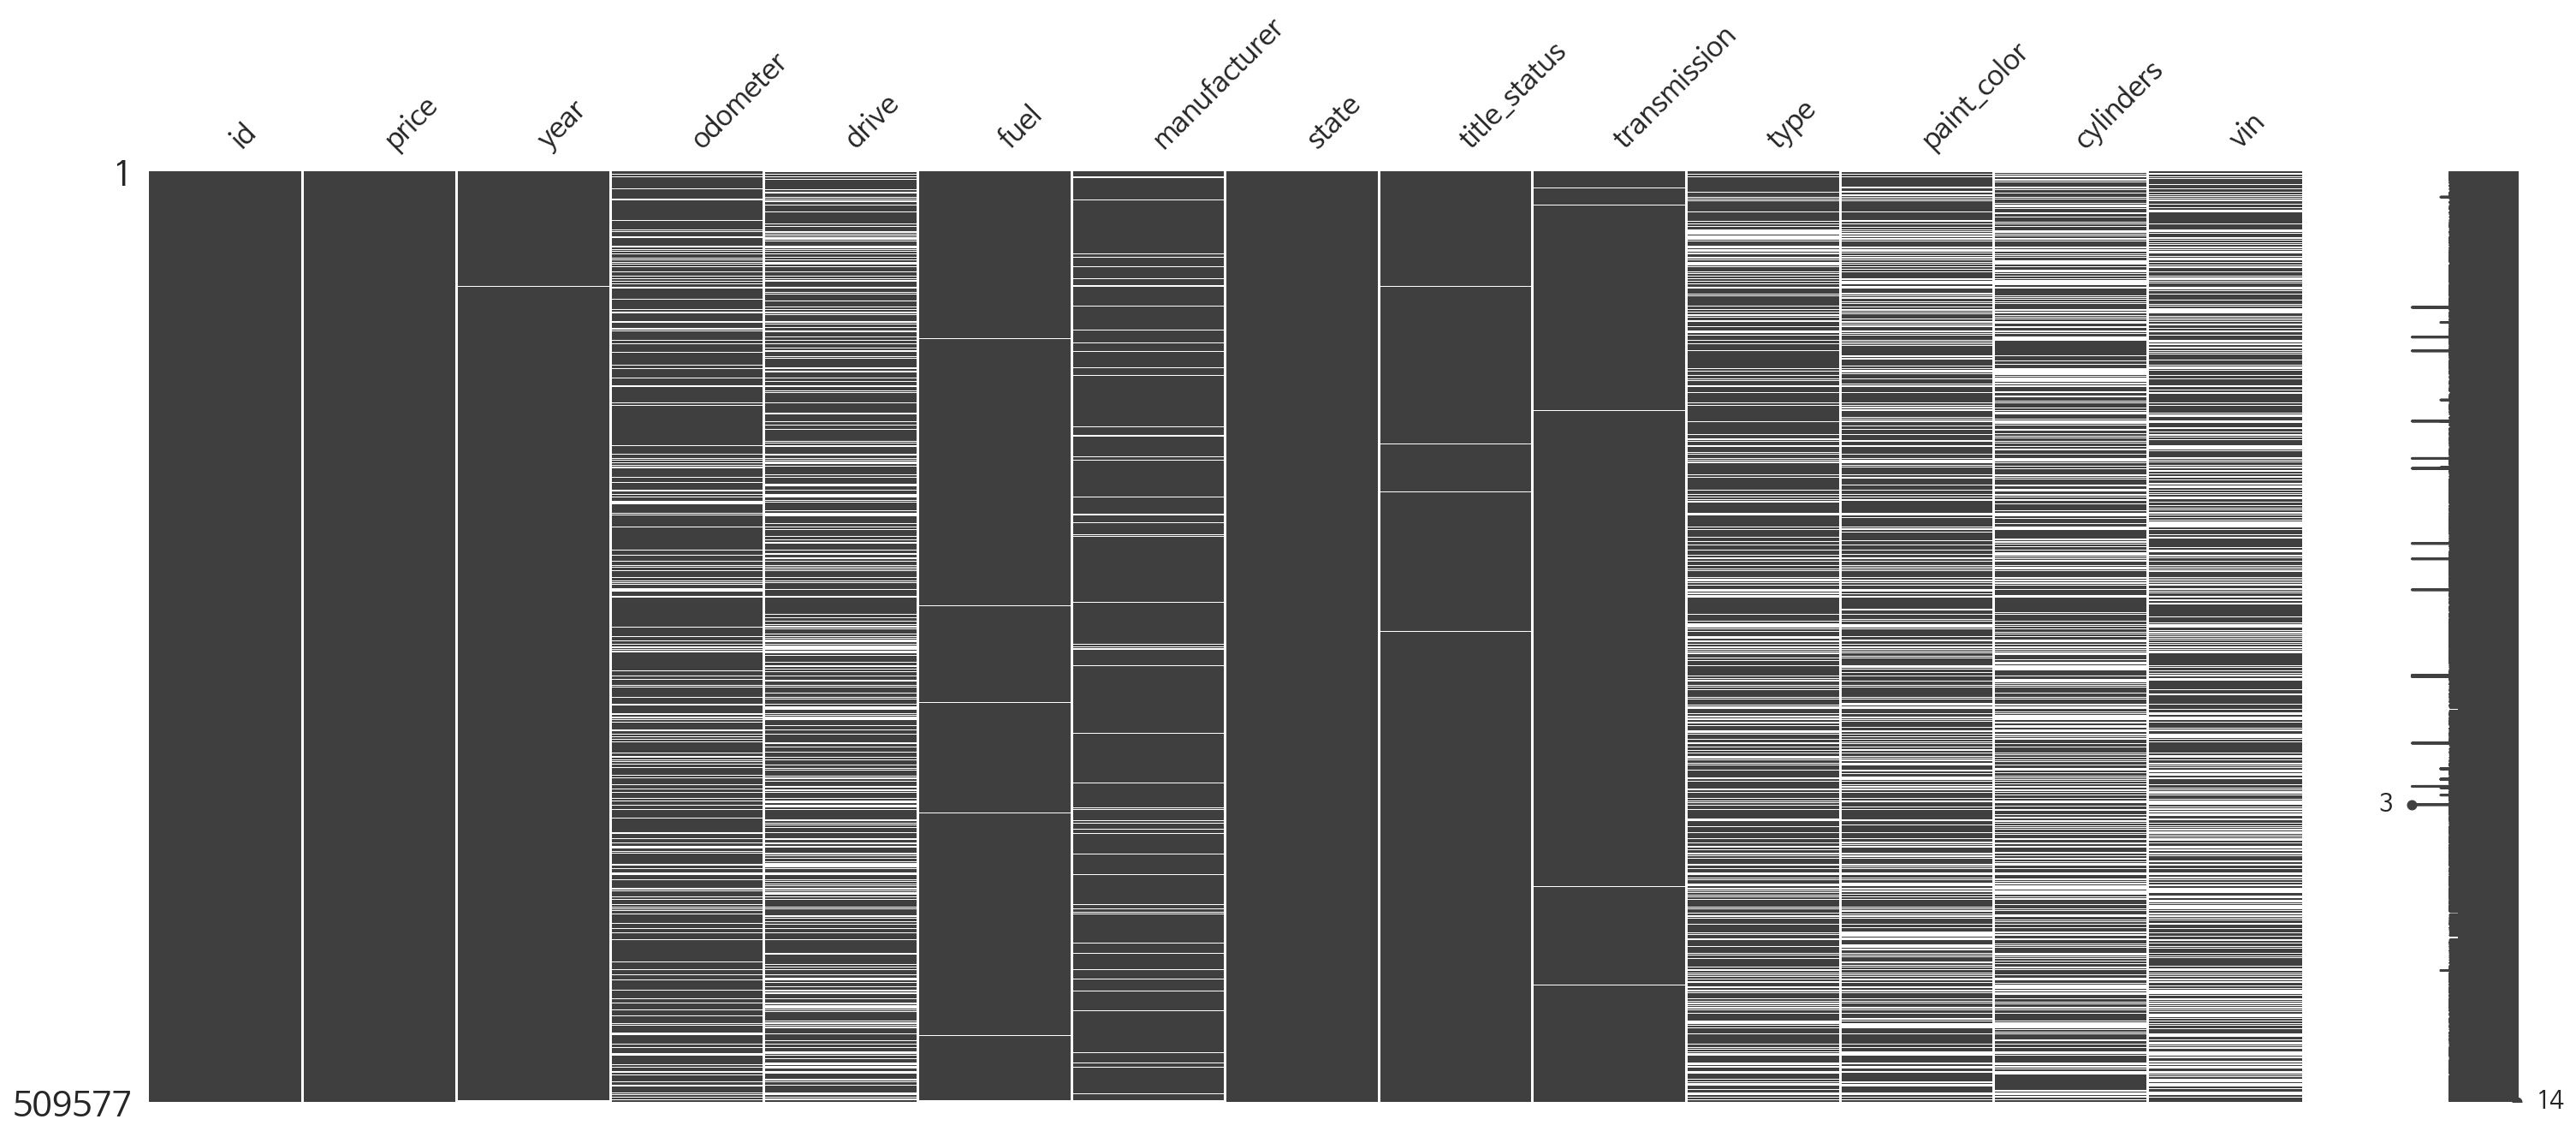

In [241]:
msno.matrix(start_df)

#### 결측치 수치화

In [127]:
def columns_na_percentage(columns):
    for column in columns:
        percentage = round(100 -(len(raw_data['{}'.format(column)].dropna()) / len(raw_data)) * 100,2)
        if percentage :
            print("{} : ".format(column), percentage,"%",end='\n')

In [128]:
columns_na_percentage(start_df.columns)

year :  0.3 %
odometer :  18.12 %
drive :  28.29 %
fuel :  0.78 %
manufacturer :  4.47 %
title_status :  0.6 %
transmission :  0.73 %
type :  27.77 %
paint_color :  32.32 %
cylinders :  39.19 %
vin :  40.71 %
condition :  45.52 %


#### 결측치 제거 

In [129]:
start_df = start_df.dropna(axis=0)
start_df.shape

(88325, 15)

## 차대 번호(vin)를 활용한 데이터 필터링

- **Step1**
    - 중복된 'vin'을 가지고 있는 데이터 삭제

In [130]:
df = start_df.loc[start_df['vin'].drop_duplicates(keep='last').index]
df.shape

(58896, 15)

- **Step2**
    - 'vinaudit.com'이 제공하는 api를 이용
    - ####  'vinaudit.com'의 데이터 베이스
     <img src="./img/img1.png" width="1000">

- **데이터 출처**
    - 자동차 이력 제공시스템 : (NMVTIS/National Motor Vehicle Title Information System)
    - 미국 도로교통 안전국 : (NHTSA / National Highway Traffic Safety Administration)
    - 미국 교통부 연방차량안전국 : (Federal Motor Carrier Safety Administration, FMCSA) 
    - 그외 미국 정부 기관과 관련된 업체 및 파트너사

### 데이터 크롤링

In [131]:
last1= pd.read_csv('./crawlinf_raw_data/vin_crawling_data.csv')
last2 = pd.read_csv('./crawlinf_raw_data/20000-28500vin_crawling.csv')
last3 = pd.read_csv('./crawlinf_raw_data/vin_df.csv')
last4 = pd.read_csv('./crawlinf_raw_data/last4.csv')


vin_crawling_data = pd.concat([last1,last2,last3,last4])

# 대문자 변경
vin_crawling_data['vin'] = vin_crawling_data['vin'].str.upper()
# 중복제거
vin_crawling_data_drop_dupli = vin_crawling_data.drop_duplicates('vin',keep='first')
vin_crawling_data_drop_dupli= vin_crawling_data_drop_dupli[vin_crawling_data_drop_dupli.columns.difference(['id','Unnamed: 0','Unnamed: 0.1','og_vin'])]

# 대문자 변경
df['vin'] = df['vin'].str.upper()

# merge
final = pd.merge(df,vin_crawling_data_drop_dupli,on='vin')

# 중복 제거
final_drop_dupli = final.drop_duplicates('vin',keep='first')

df = final_drop_dupli[final_drop_dupli.columns.difference(['id_y','Unnamed: 0','Unnamed: 0.1','og_vin'])]
df.shape

(58787, 27)

# 크롤링 데이터 분석

<img src="./img/img3.png" width="600">

- **데이터 사용처**
    - Carmax,carfax등 미국 중고차 매매 업체
    - Vincheck등 중고차 매물 검색 업체

|컬럼명|설명|
|:------|:---|
| **above** | 최대 가격|
|**average** | 평균 가격|
|**below** | 최소 가격 |
|**certainty** | 정확도 |
|**count**|  거래 횟수|
|**error** |  에러 메세지 |
|**mileage**|  주행 거리 |
|**period**|  거래 시기|
|**stdev**|  표준 편차|
|**success**|  성공 여부|
|**vehicle**|  차량 정보 (연식, 제조사, 모델명)|

### 크롤링 데이터를 활용한 데이터 필터링

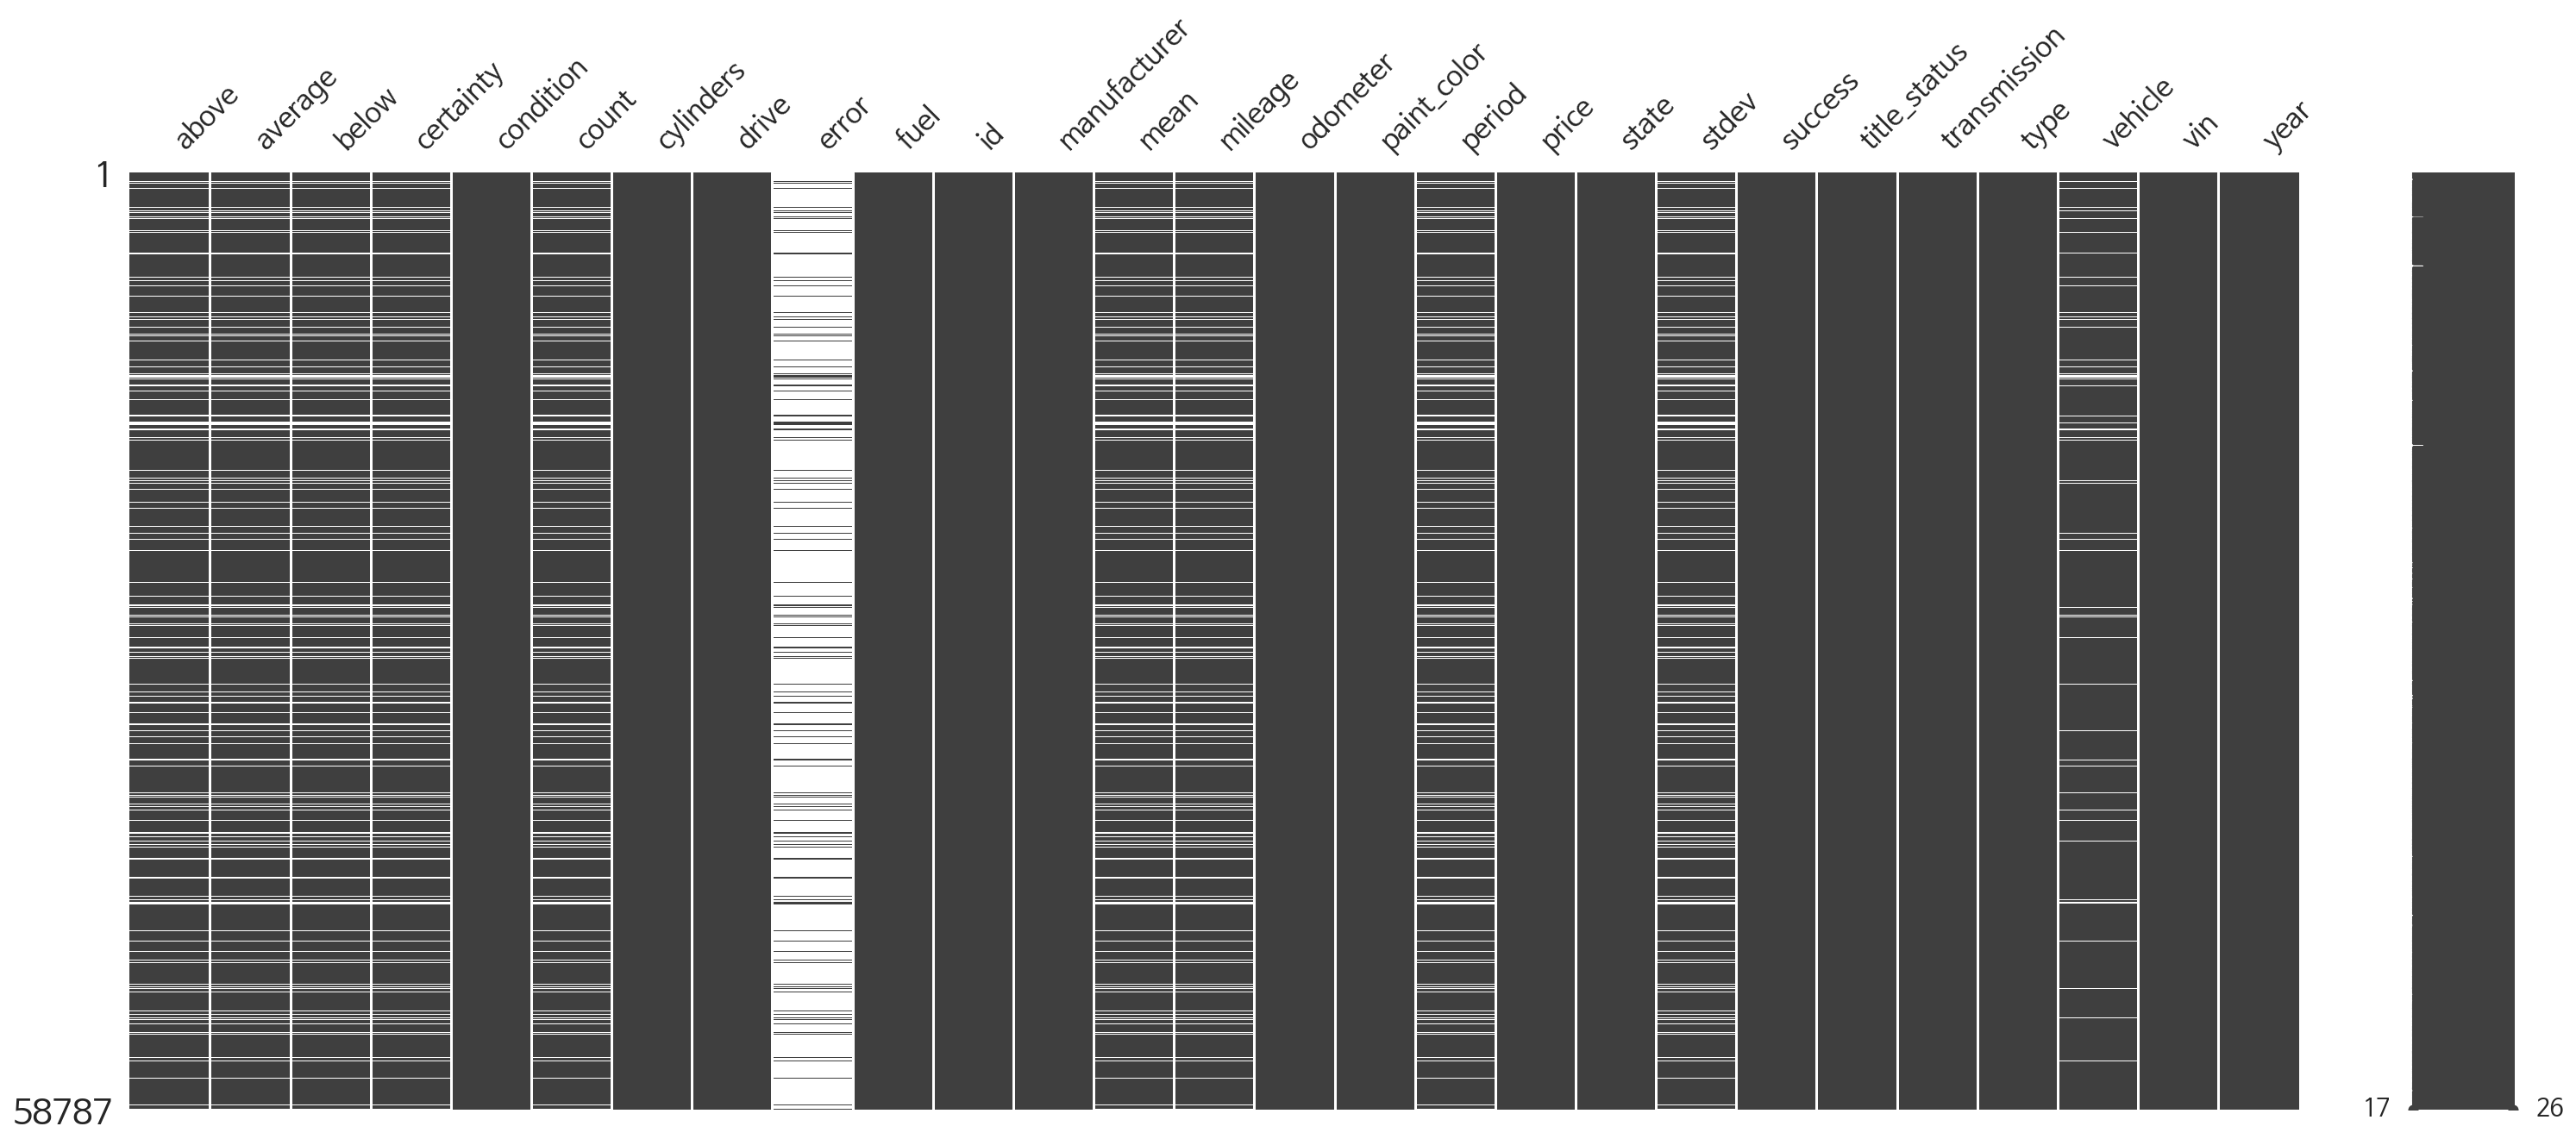

In [132]:
msno.matrix(df)

### 잘못된 vin 값 & 사고이력, 가격등을 확인할수 없는 1980년도 이전 차량

In [133]:
df['error'].value_counts()

no_data        3825
invalid_vin    2970
Name: error, dtype: int64

In [147]:
test=df[df.columns.difference(['error'])]

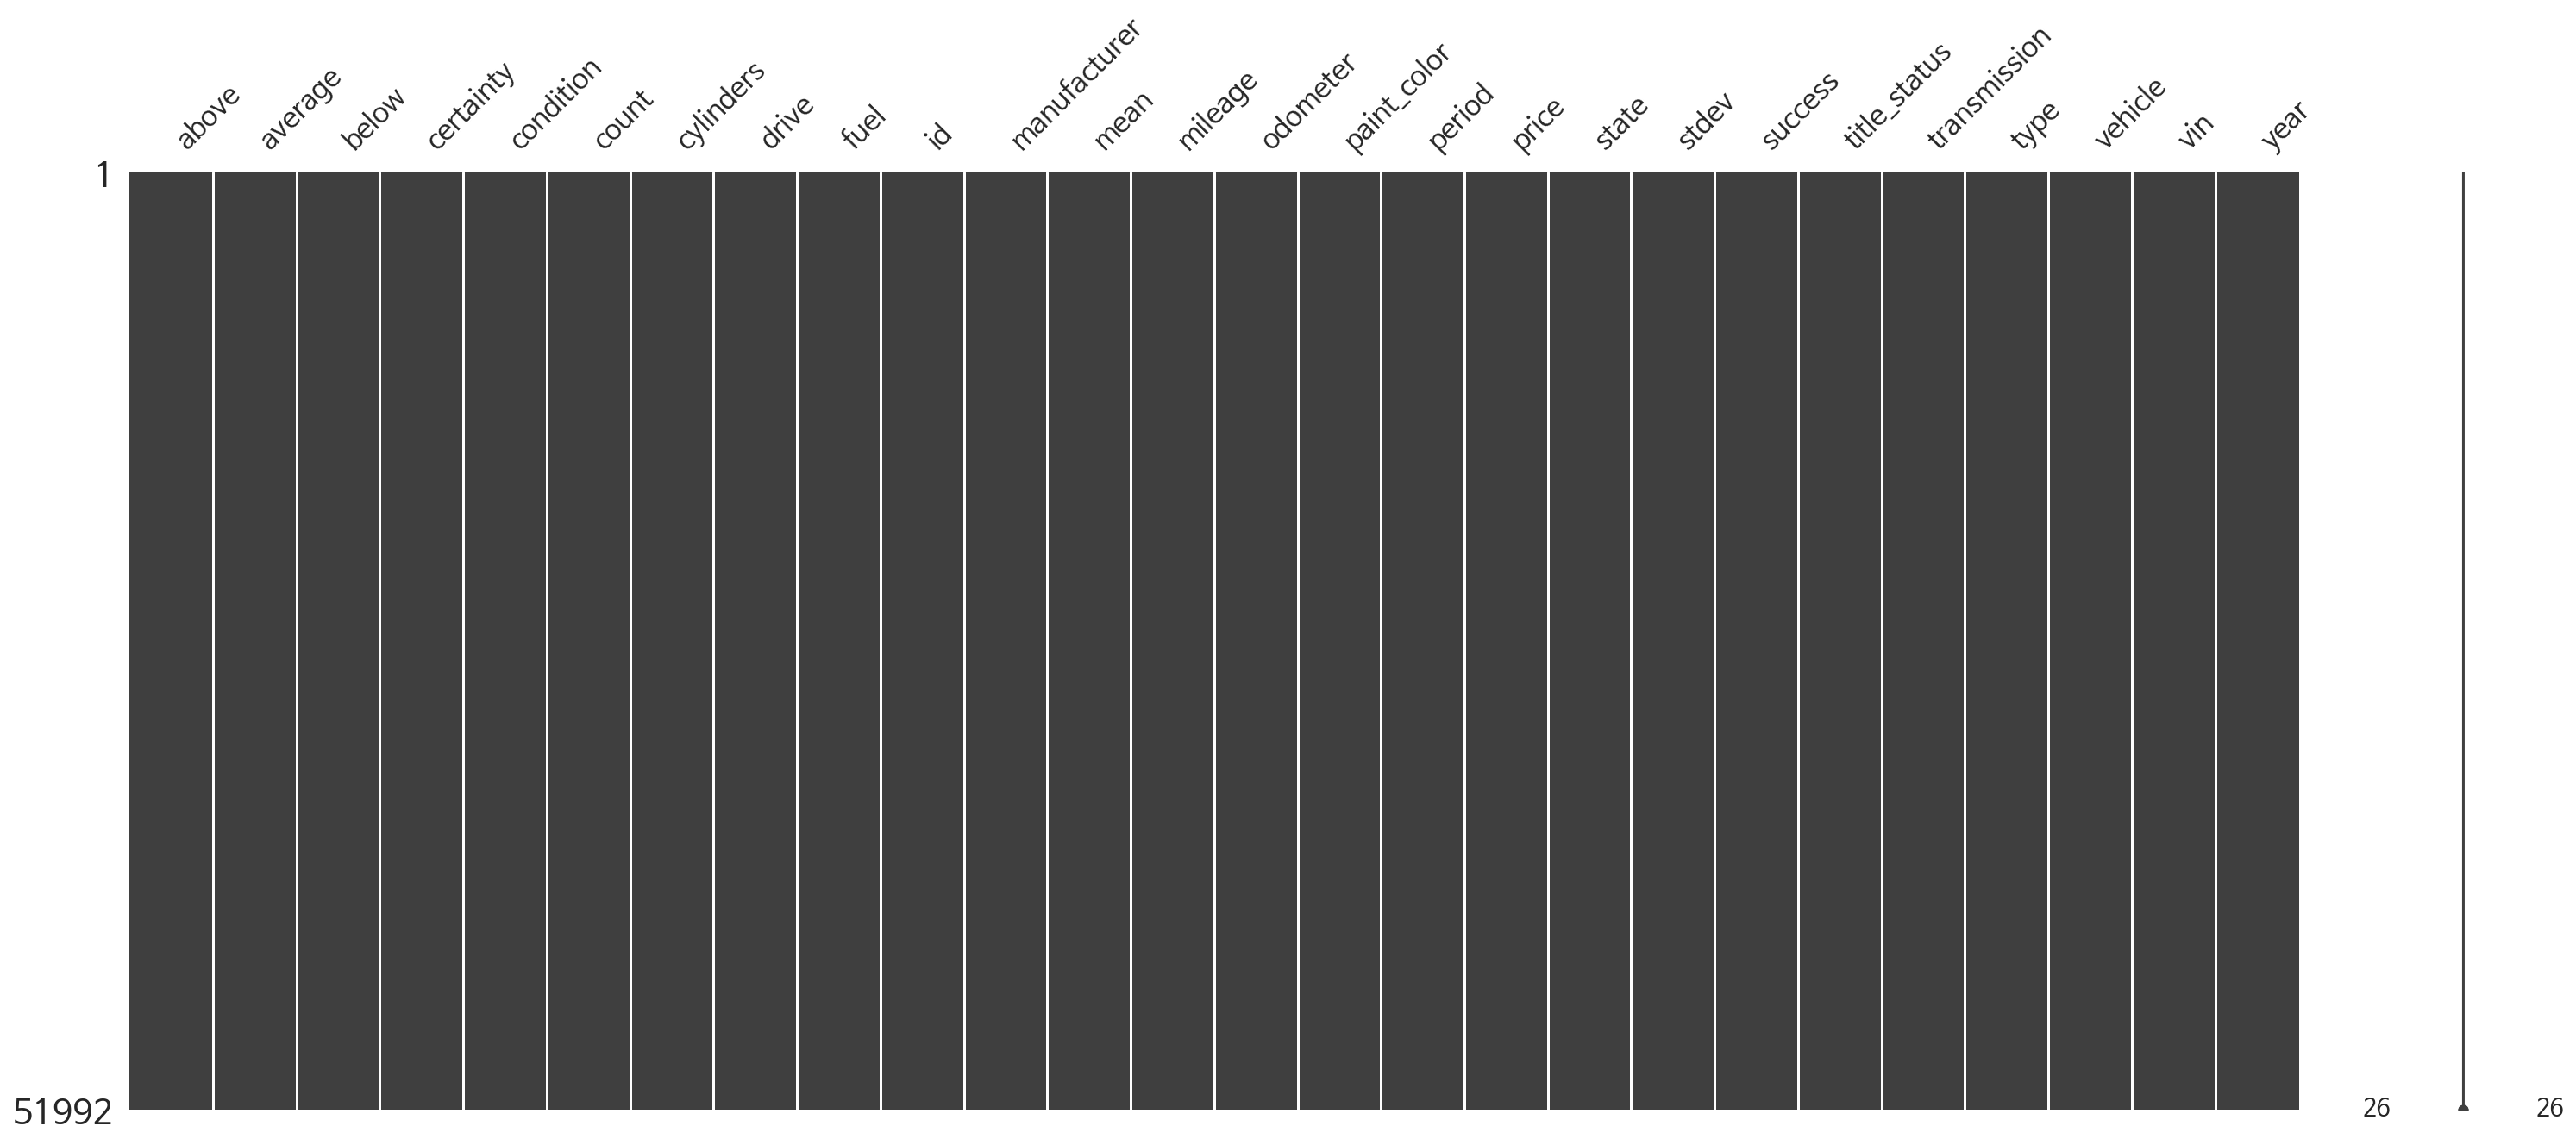

In [135]:
test = test.dropna(axis=0)
msno.matrix(test)

# 데이터 전처리

### 가격 필터링

In [29]:
test2[['above', 'average', 'below','stdev']]

,above,average,below,stdev
0,20878.90,18399.90,15920.90,2479.00
3,31460.64,28380.64,25300.64,3080.00
10,32616.48,29832.48,27048.48,2784.00
11,20245.26,18517.26,16789.26,1728.00
12,13202.72,9909.72,6616.72,3293.00
...,...,...,...,...
77637,35943.11,31987.11,28031.11,3956.00
77639,37179.79,32672.79,28165.79,4507.00
77641,8547.01,6899.01,5251.01,1648.00
77642,32712.95,29971.95,27230.95,2741.00


In [136]:
def get_sigma_data_by_price(num):
    global test2
    test2 = test[(test['price'] >= (test['average'] - (test['stdev']*num))) & (test['price'] <= (test['average'] + (test['stdev']*num)))]
    print("{} sigma data : ".format(num),test2.shape)

In [148]:
get_sigma_data_by_price(2)
test2.shape

2 sigma data :  (41265, 26)


(41265, 26)

In [149]:
test2['year'] = test2['year'].astype('int')

### 주행거리 필터링

In [ ]:
# odometer와 mileage가 다른 데이터
test2[test2['mileage'] != test2['odometer']]

In [ ]:
len(test2[test2['mileage'] < 100])

### 박스플롯, 스캐터 플롯

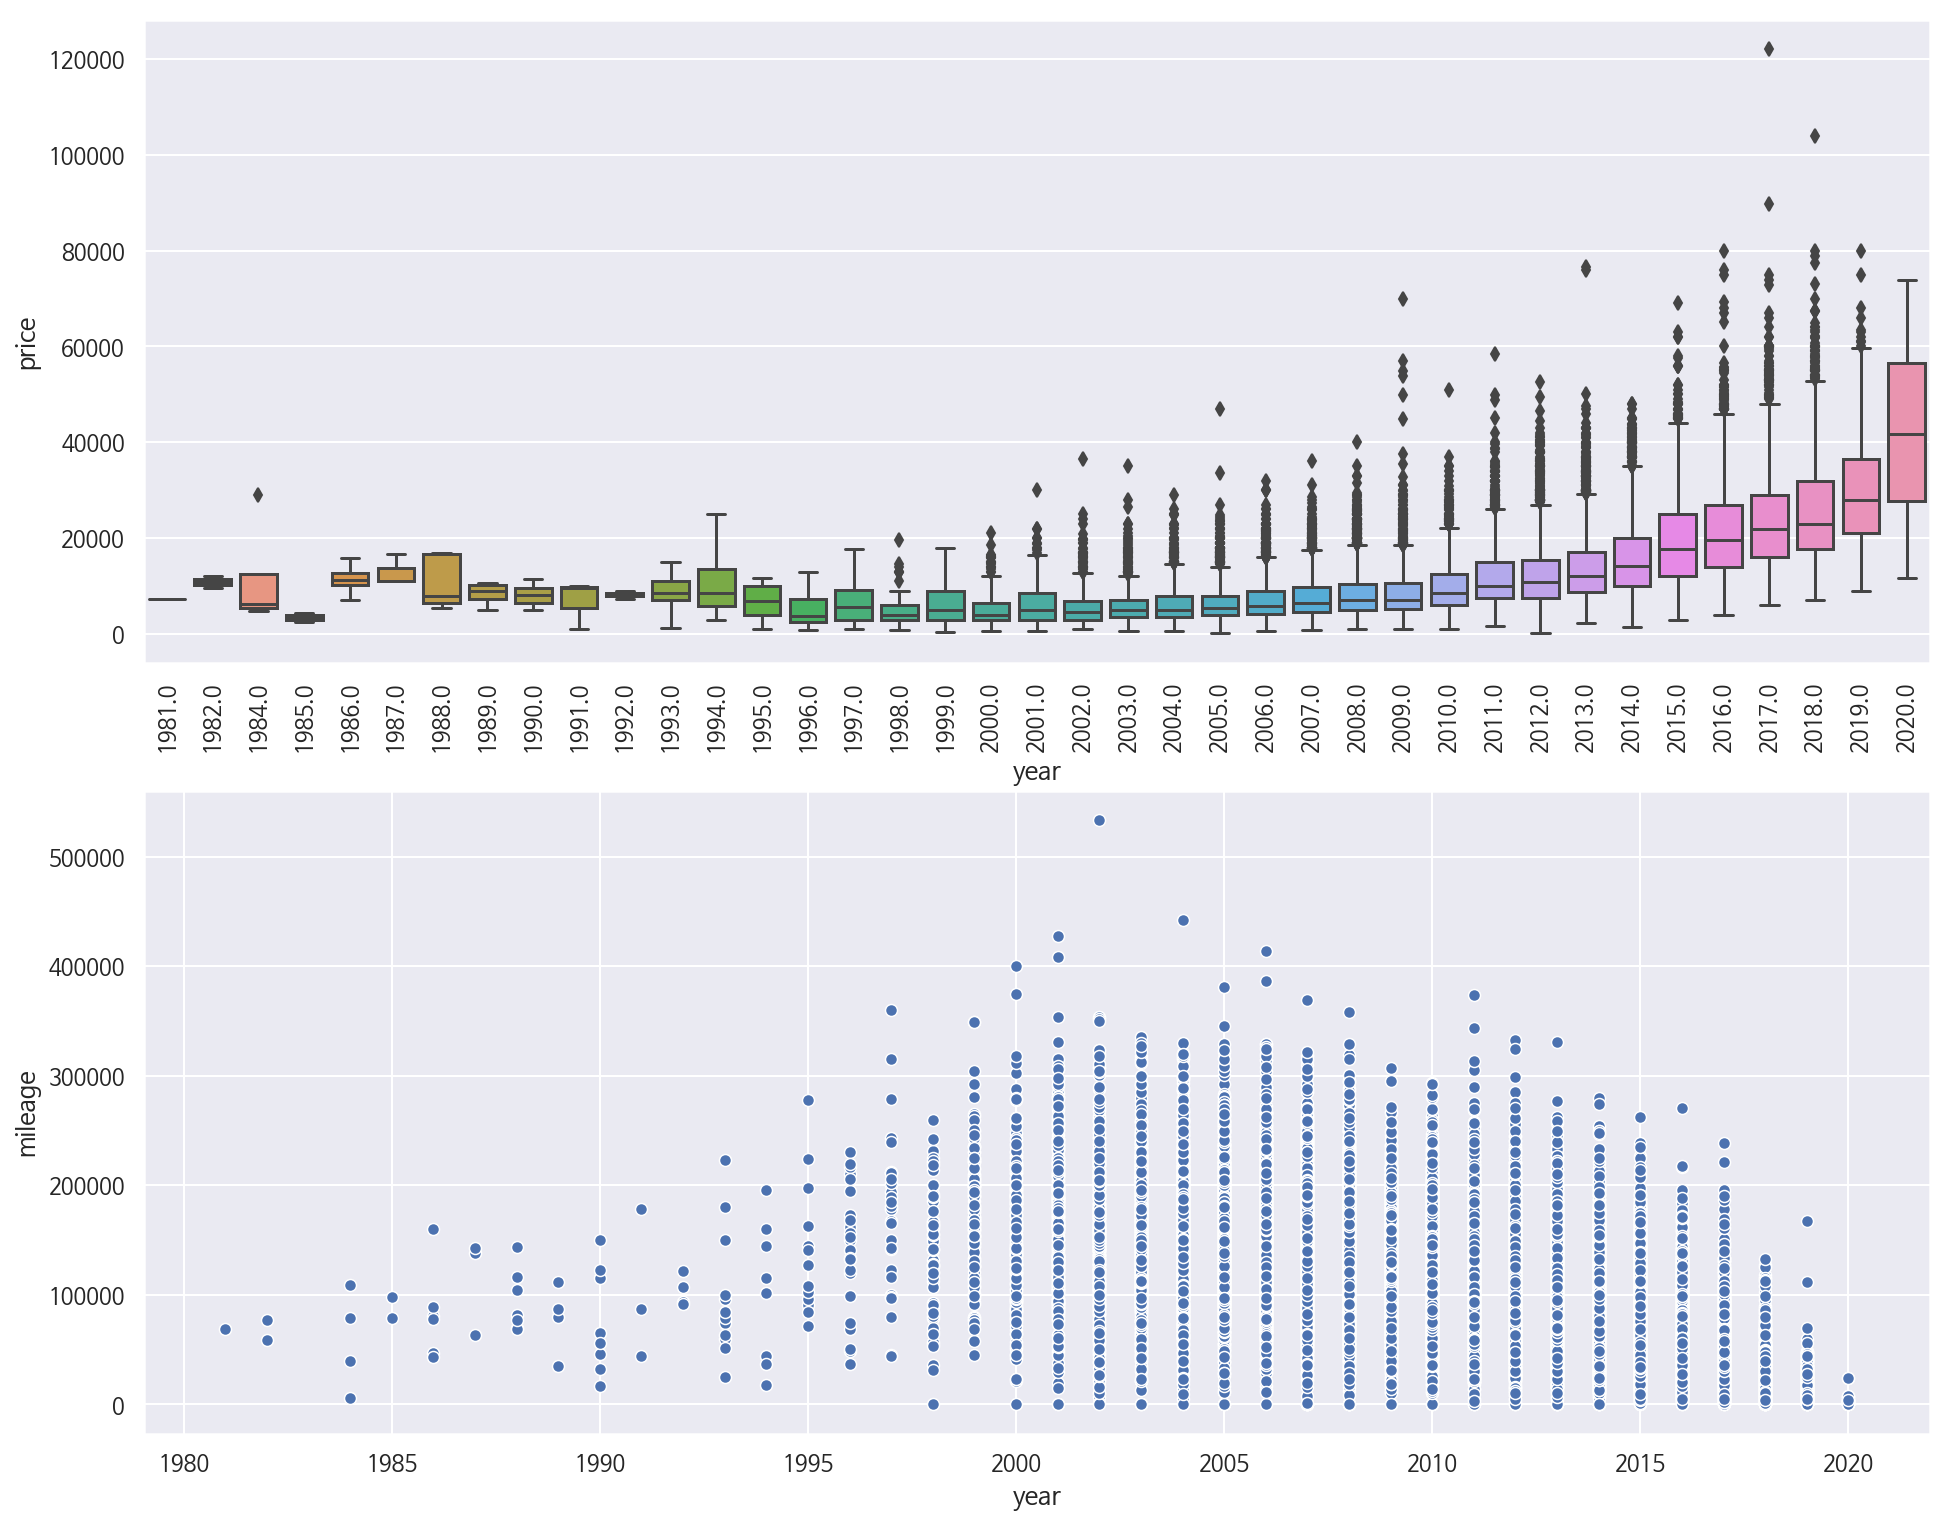

In [138]:
plt.figure(figsize=(16,13))
plt.subplot(211)
sns.boxplot(x="year", y="price", data = test2)
plt.xticks(rotation=90)
plt.subplot(212)
sns.scatterplot(test2['year'],test2['mileage'])
# plt.subplot(313)
# sns.scatterplot(test2['year'],test2['price'])

plt.show()

## 플롯 그린후 눈으로 본 데이터

In [409]:
# year 수정해 줘야 하는 데이터
test2[test2['year'] < 1980]

,above,average,below,certainty,count,cylinders,drive,fuel,id_x,manufacturer,mean,mileage,odometer,paint_color,period,price,state,stdev,success,title_status,transmission,type,vehicle,vin,year,vin_year
49431,31752.09,28691.09,25630.09,99.00,240.00,8 cylinders,rwd,gas,7035287698,pontiac,28691.09,36211.00,36211.00,blue,"['2019-12-14', '2020-03-26']",27988,mt,3061.00,True,clean,automatic,other,2019 Toyota Sienna,5TDYZ3DC0KS008940,1968,2019


In [410]:
test2[test2['mileage'] > 500000]

,above,average,below,certainty,count,cylinders,drive,fuel,id_x,manufacturer,mean,mileage,odometer,paint_color,period,price,state,stdev,success,title_status,transmission,type,vehicle,vin,year,vin_year
28776,9045.70,6984.70,4923.70,65.00,4.00,8 cylinders,4wd,gas,7044009302,toyota,6984.70,533000.00,533000.00,grey,"['2019-10-03', '2020-02-20']",6500,ga,2061.00,True,clean,automatic,SUV,2002 Toyota Land Cruiser Base,JTEHT05J722017912,2002,2002


In [411]:
test2[test2['price'] > 190000]

,above,average,below,certainty,count,cylinders,drive,fuel,id_x,manufacturer,mean,mileage,odometer,paint_color,period,price,state,stdev,success,title_status,transmission,type,vehicle,vin,year,vin_year
60128,202032.56,182660.56,163288.56,90.00,16.00,8 cylinders,4wd,gas,7045671330,mercedes-benz,182660.56,7584.00,7584.00,white,"['2019-10-03', '2020-03-26']",193982,oh,19372.00,True,clean,automatic,SUV,2019 Mercedes-Benz,WDCYC7HJ3KX301396,2019,2019


In [399]:
len(test2[test2['mileage'] < 100])

60

In [ ]:
# vin을 이용해 두 데이터 merge

In [ ]:
# 상태 확인을 통해 invalid_vin, no_data 등 처리 (잘못기입된 vin 필터링, 아웃라이어라고 볼수있는 odometer 제거)

In [ ]:
# 우리 데이터의 가격과, 크롤링해온 데이터의 가격을 비교 (가격에 대한 아웃라이어 제거, 2sigma)
# 상의 필요, 함수로 만들어서 조절할수 있게 만들기

### 추가 필터링

In [ ]:
# price, year, odometer 값이 0인 경우 제거

In [ ]:
# 가격 패턴 보이는 것들 제거

## 변수탐색

### 종속변수 - 가격(price)

In [413]:
test2.price.sort_values(ascending=False)[:20]

60128    193982
29627    139995
20351    121995
10976    114950
73531    109995
14452    103999
16013     89800
61873     82991
29598     80905
77616     79997
56725     79995
19853     79970
65025     78900
14172     77500
23913     75999
30753     75977
36235     75000
20027     74999
56689     74900
71749     73915
Name: price, dtype: int64

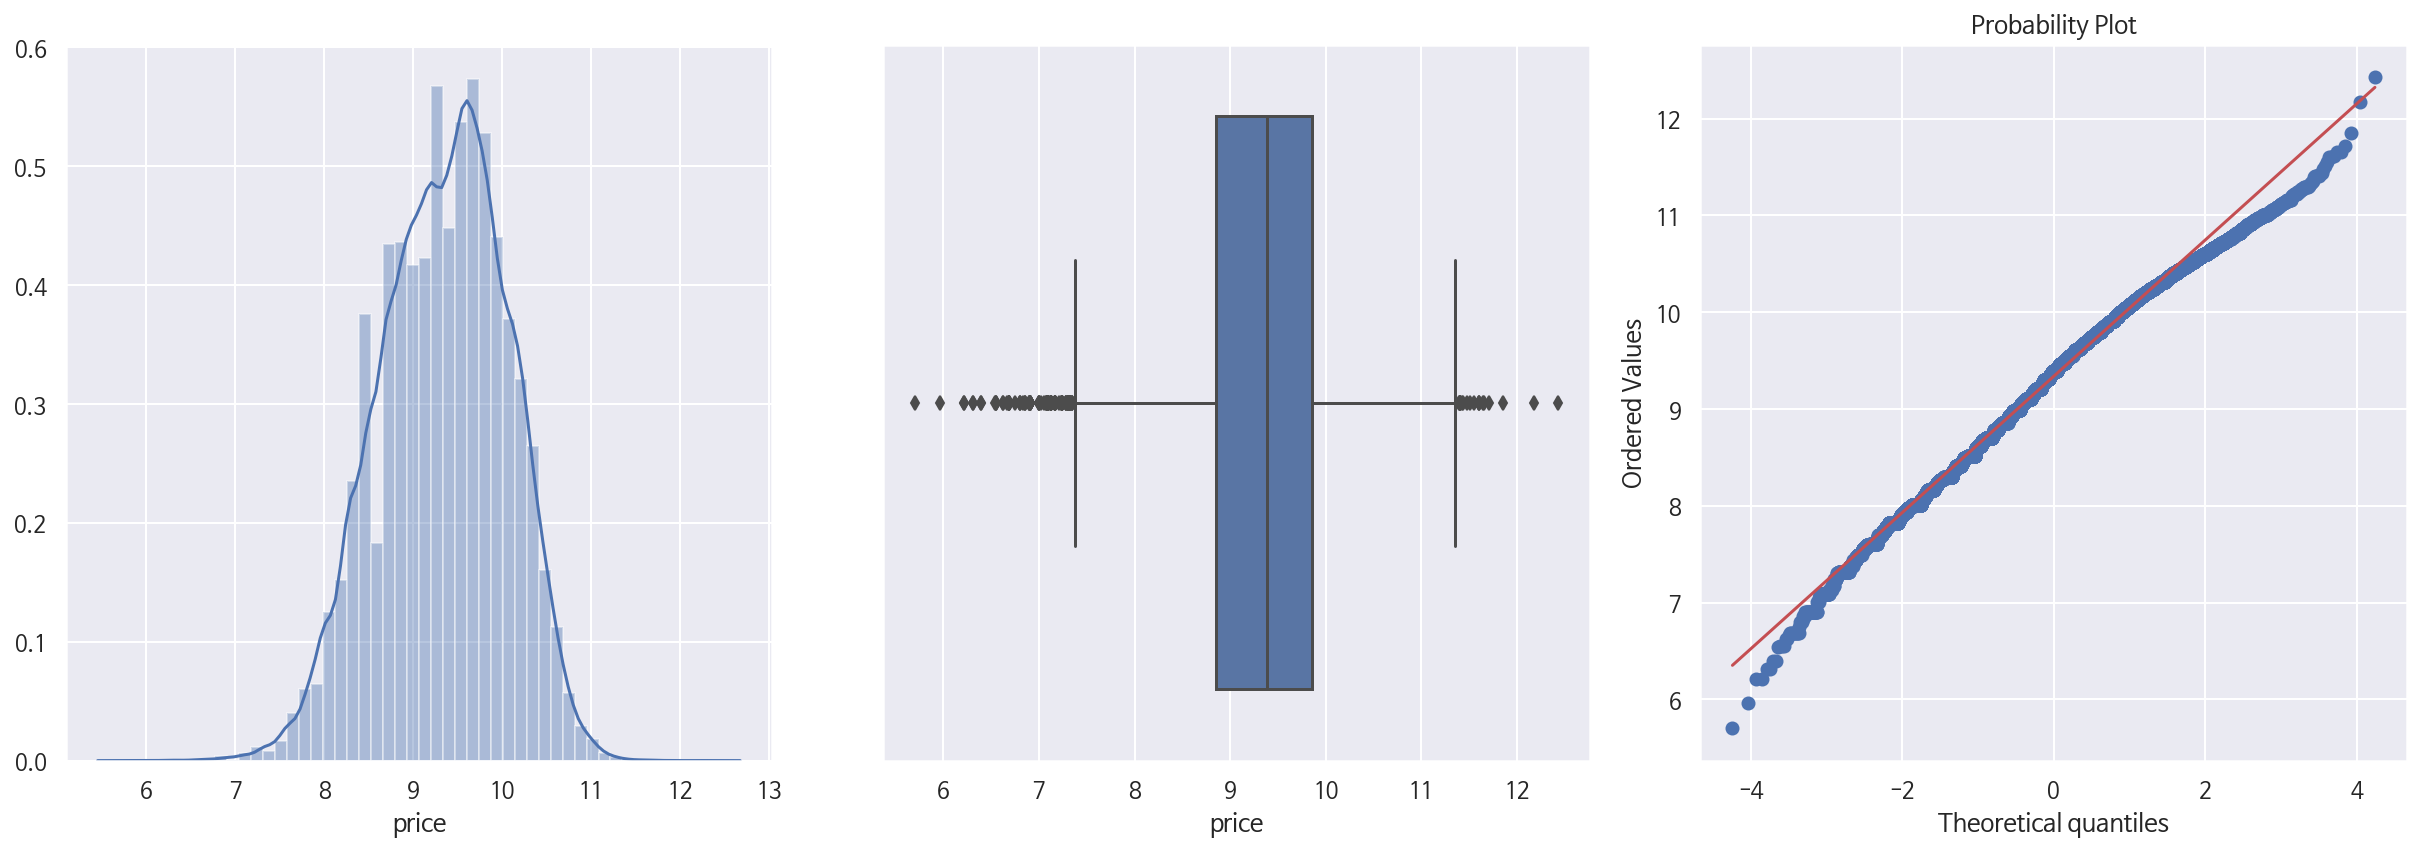

In [422]:
# 0값 제거등 데이터 필터링후 다시 실행
plt.figure(figsize=(17,6))

plt.subplot(131)
sns.distplot(np.log(test2['price']))

plt.subplot(132)
sns.boxplot(np.log(test2['price']))

plt.subplot(133)
stats.probplot(np.log(test2['price']),plot=plt)
plt.tight_layout()
plt.show()

### 독립변수

### 연식

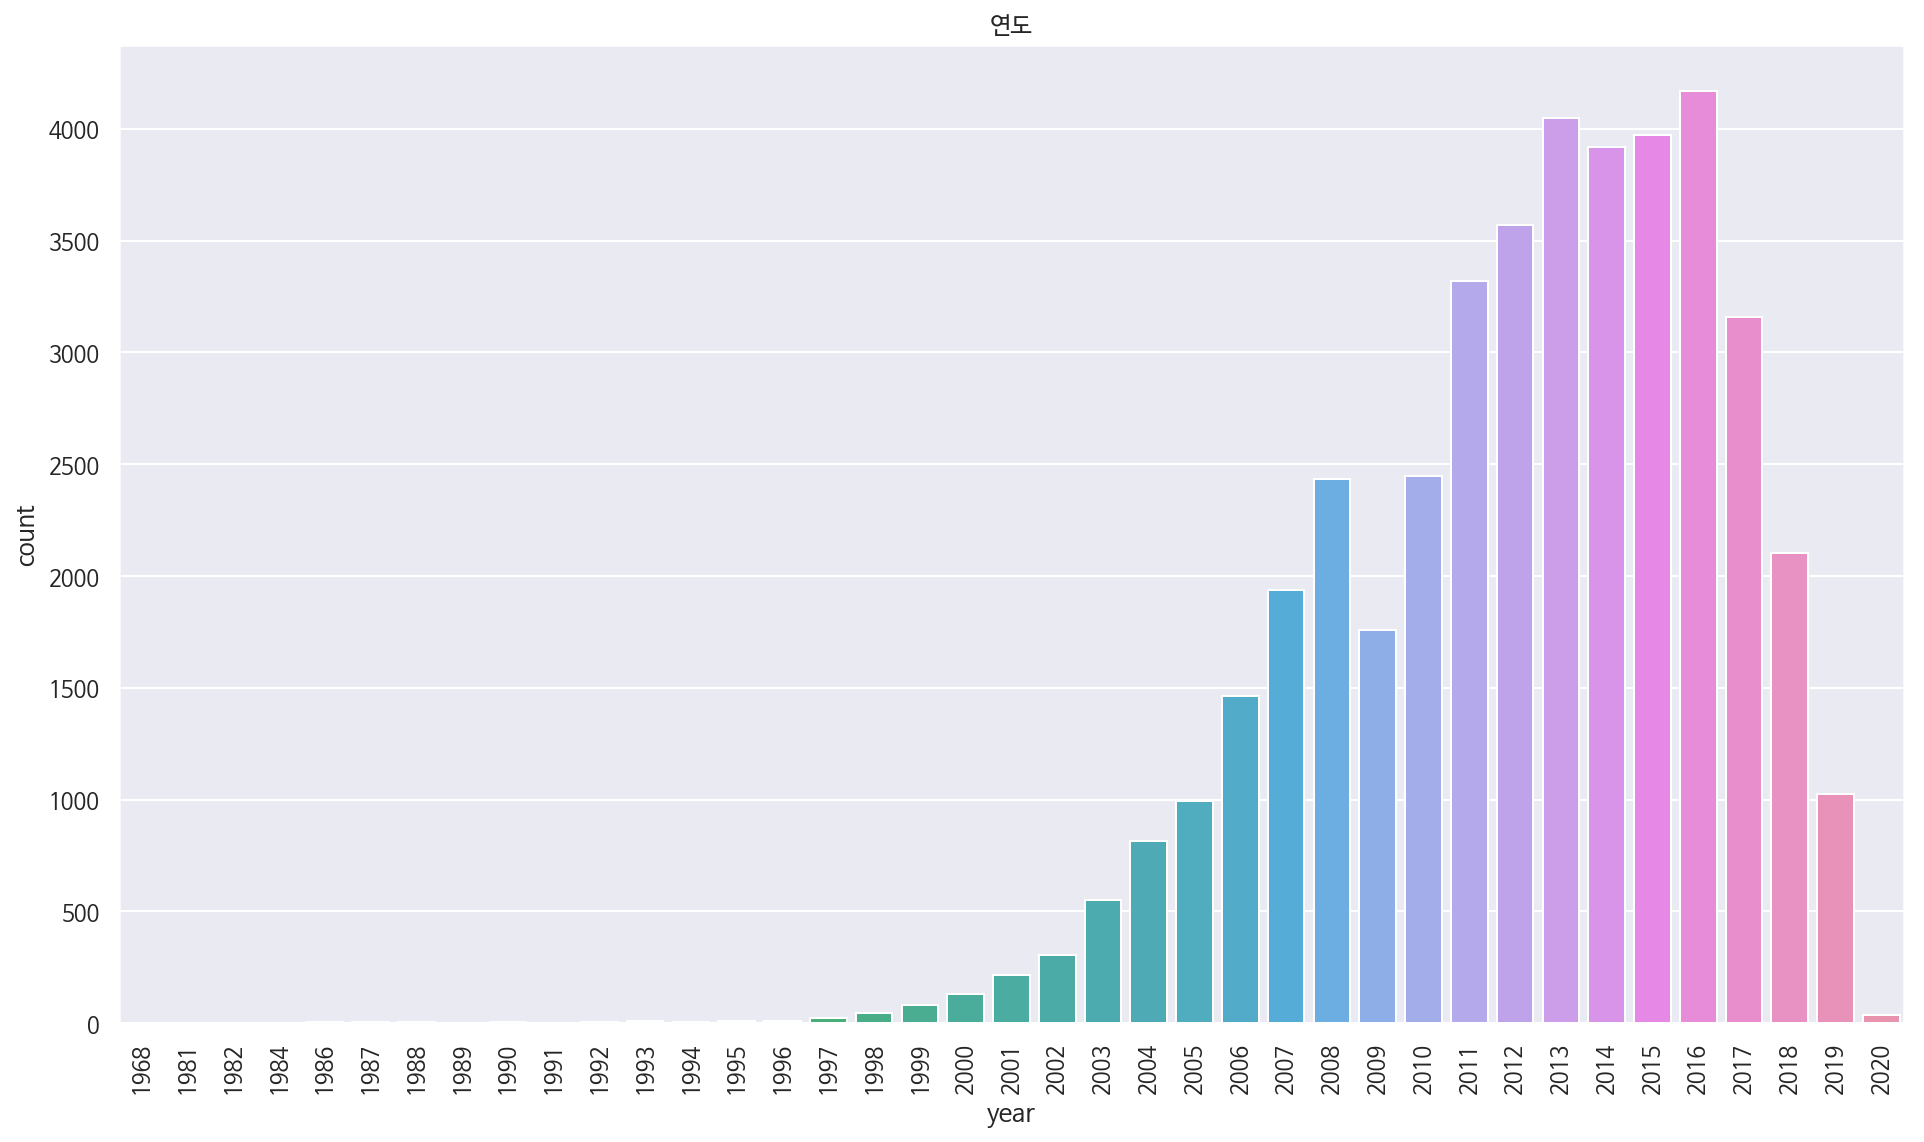

In [414]:
plt.figure(figsize=(16,9))
sns.countplot(
    test2['year']
)
plt.title("연도")
plt.xticks(rotation=90)
plt.show()

#### 연식과 가격

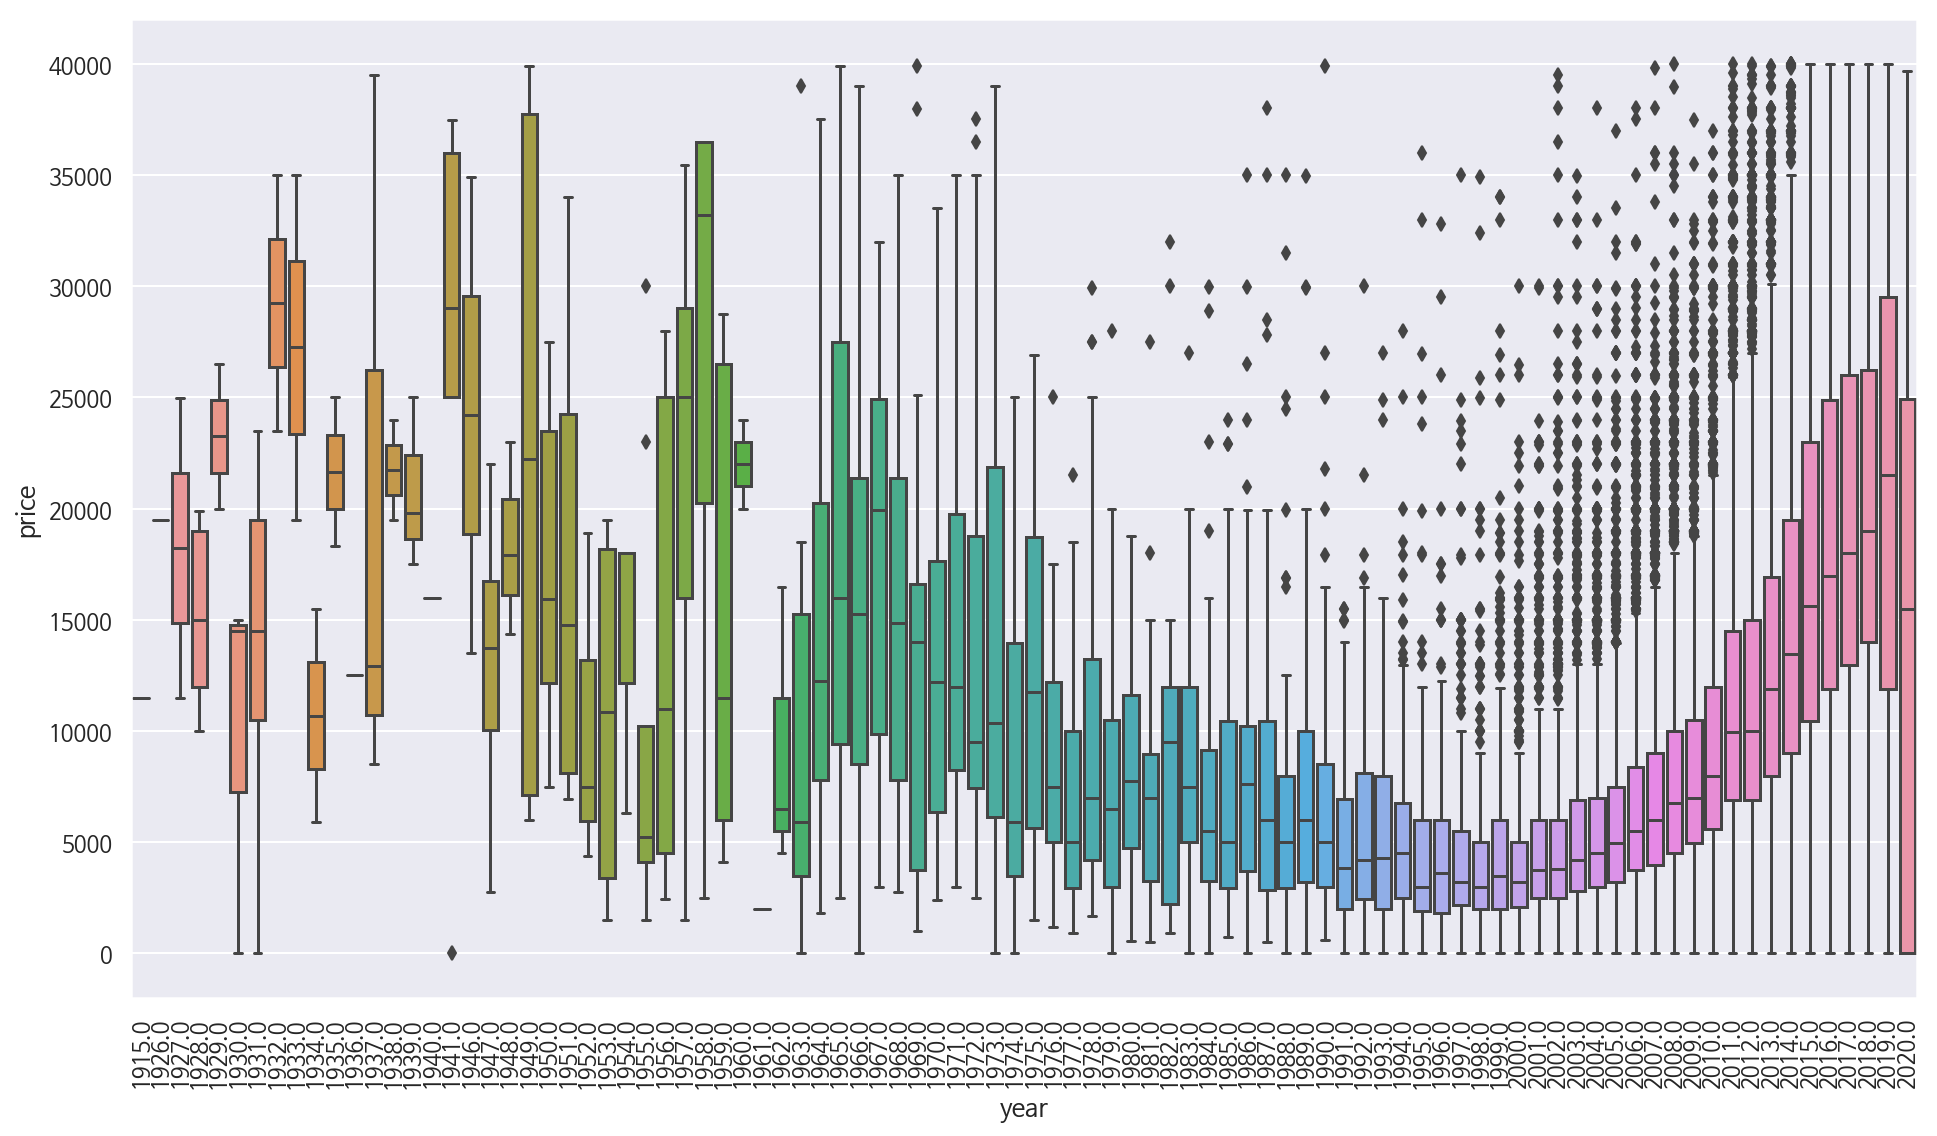

In [262]:
plt.figure(figsize=(16,9))

# price_over_98pct = df["price"].quantile(.98)

# plot_df = df[df['price'] < price_over_98pct]

sns.boxplot(x="year", y="price", data = plot_df)
plt.xticks(rotation=90)

plt.show()

### 주행거리

In [248]:
df.columns

Index(['id', 'price', 'year', 'odometer', 'drive', 'fuel', 'manufacturer',
       'state', 'title_status', 'transmission', 'type', 'paint_color',
       'cylinders', 'vin'],
      dtype='object')

### 독립변수 확인

In [294]:
for column in df.columns.difference(['id','vin','price','year']):
    print(df[column].describe(),"\n\n",df[column].unique(),end='\n\n----------------------\n\n')

count           77678
unique              8
top       6 cylinders
freq            28354
Name: cylinders, dtype: object 

 ['4 cylinders' '8 cylinders' '6 cylinders' '5 cylinders' '10 cylinders'
 '3 cylinders' 'other' '12 cylinders']

----------------------

count     77678
unique        3
top         4wd
freq      33486
Name: drive, dtype: object 

 ['4wd' 'fwd' 'rwd']

----------------------

count     77678
unique        5
top         gas
freq      71045
Name: fuel, dtype: object 

 ['gas' 'diesel' 'other' 'hybrid' 'electric']

----------------------

count     77678
unique       42
top        ford
freq      13646
Name: manufacturer, dtype: object 

 ['volkswagen' 'honda' 'subaru' 'ram' 'mercedes-benz' 'ford' 'chevrolet'
 'dodge' 'kia' 'nissan' 'toyota' 'saturn' 'jeep' 'chrysler' 'hyundai'
 'pontiac' 'mitsubishi' 'gmc' 'lexus' 'audi' 'mazda' 'fiat' 'lincoln'
 'acura' 'mini' 'volvo' 'rover' 'bmw' 'cadillac' 'infiniti' 'buick'
 'alfa-romeo' 'jaguar' 'mercury' 'tesla' 'ferrari' 'datsun'

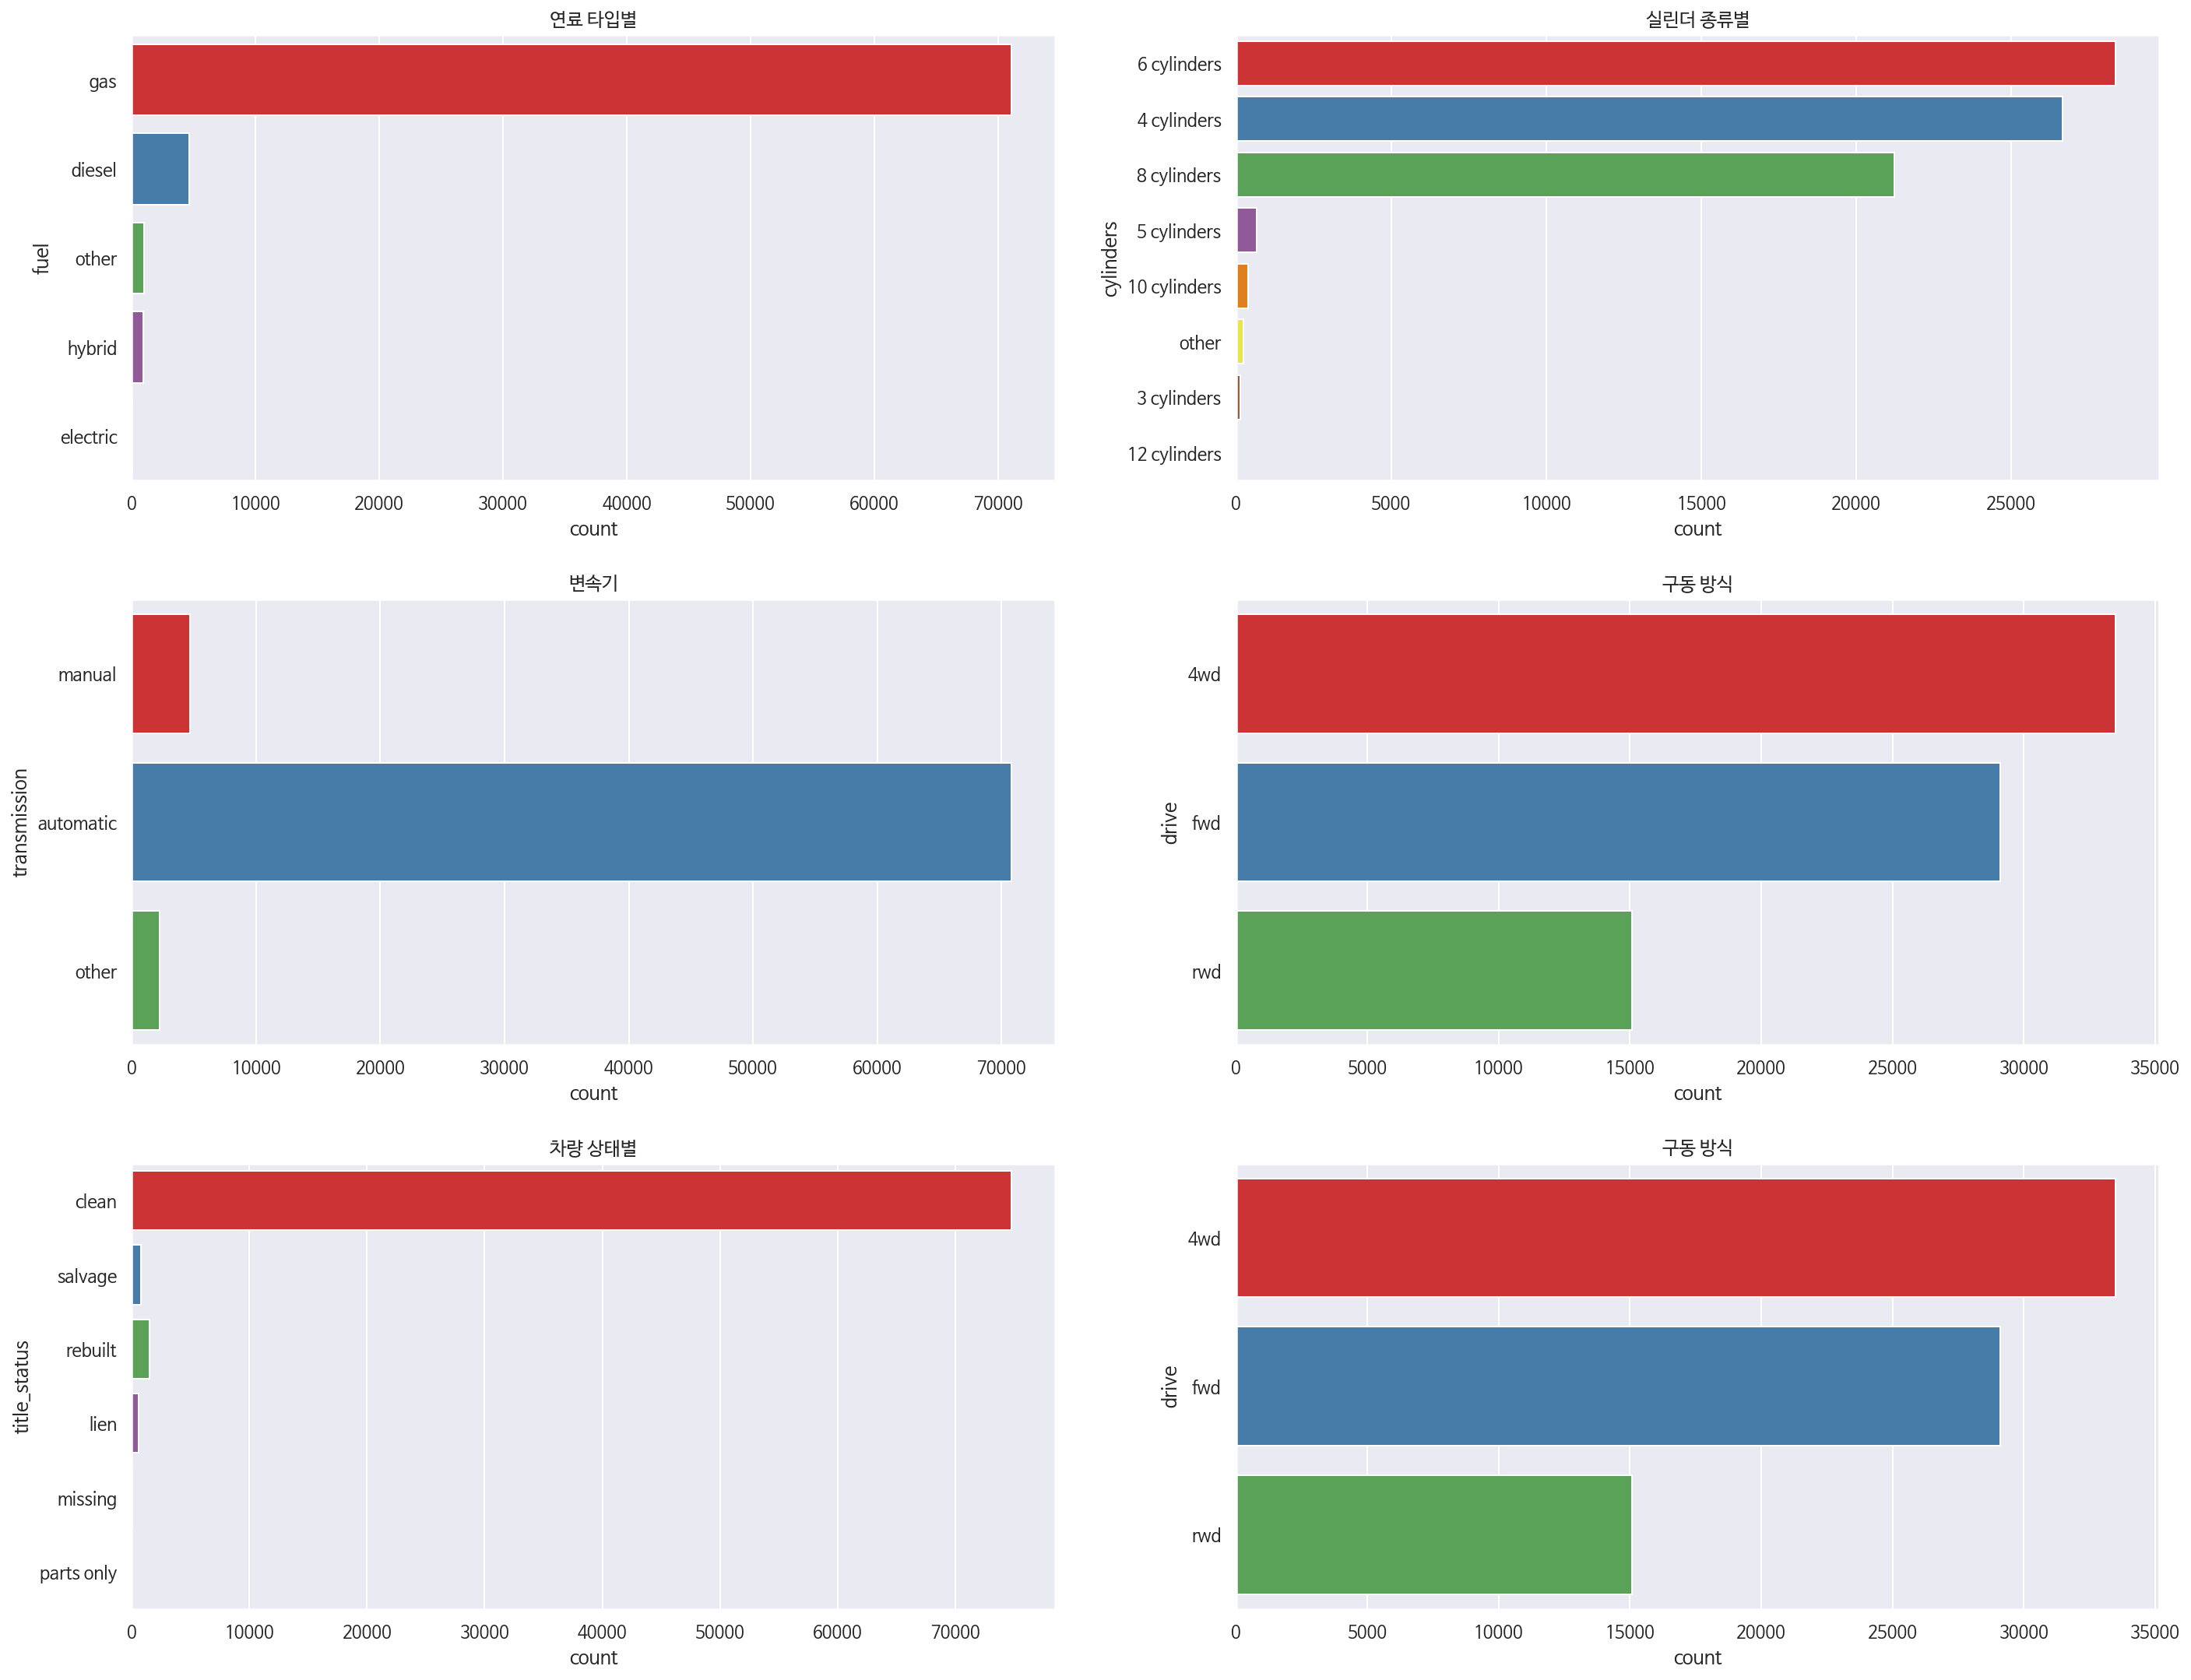

In [280]:
plt.figure(figsize=(20,30))
plt.subplot(621)
sns.countplot(
    data = df,
    y = "fuel",
    palette='Set1',
)
plt.title("연료 타입별")


plt.subplot(622)
sns.countplot(
    data = df,
    y = "cylinders",
    palette='Set1',
    order = df['cylinders'].value_counts().index

)
plt.title("실린더 종류별")


plt.subplot(623)
sns.countplot(
    data = df,
    y = "transmission",
    palette='Set1'
)
plt.title("변속기")

plt.subplot(624)
sns.countplot(
    data = df,
    y = "drive",
    palette='Set1'
)
plt.title("구동 방식")


plt.subplot(625)
sns.countplot(
    data = df,
    y = "title_status",
    palette='Set1'
)
plt.title("차량 상태별")

plt.subplot(626)
sns.countplot(
    data = df,
    y = "drive",
    palette='Set1'
)
plt.title("구동 방식")

plt.tight_layout()
plt.show()


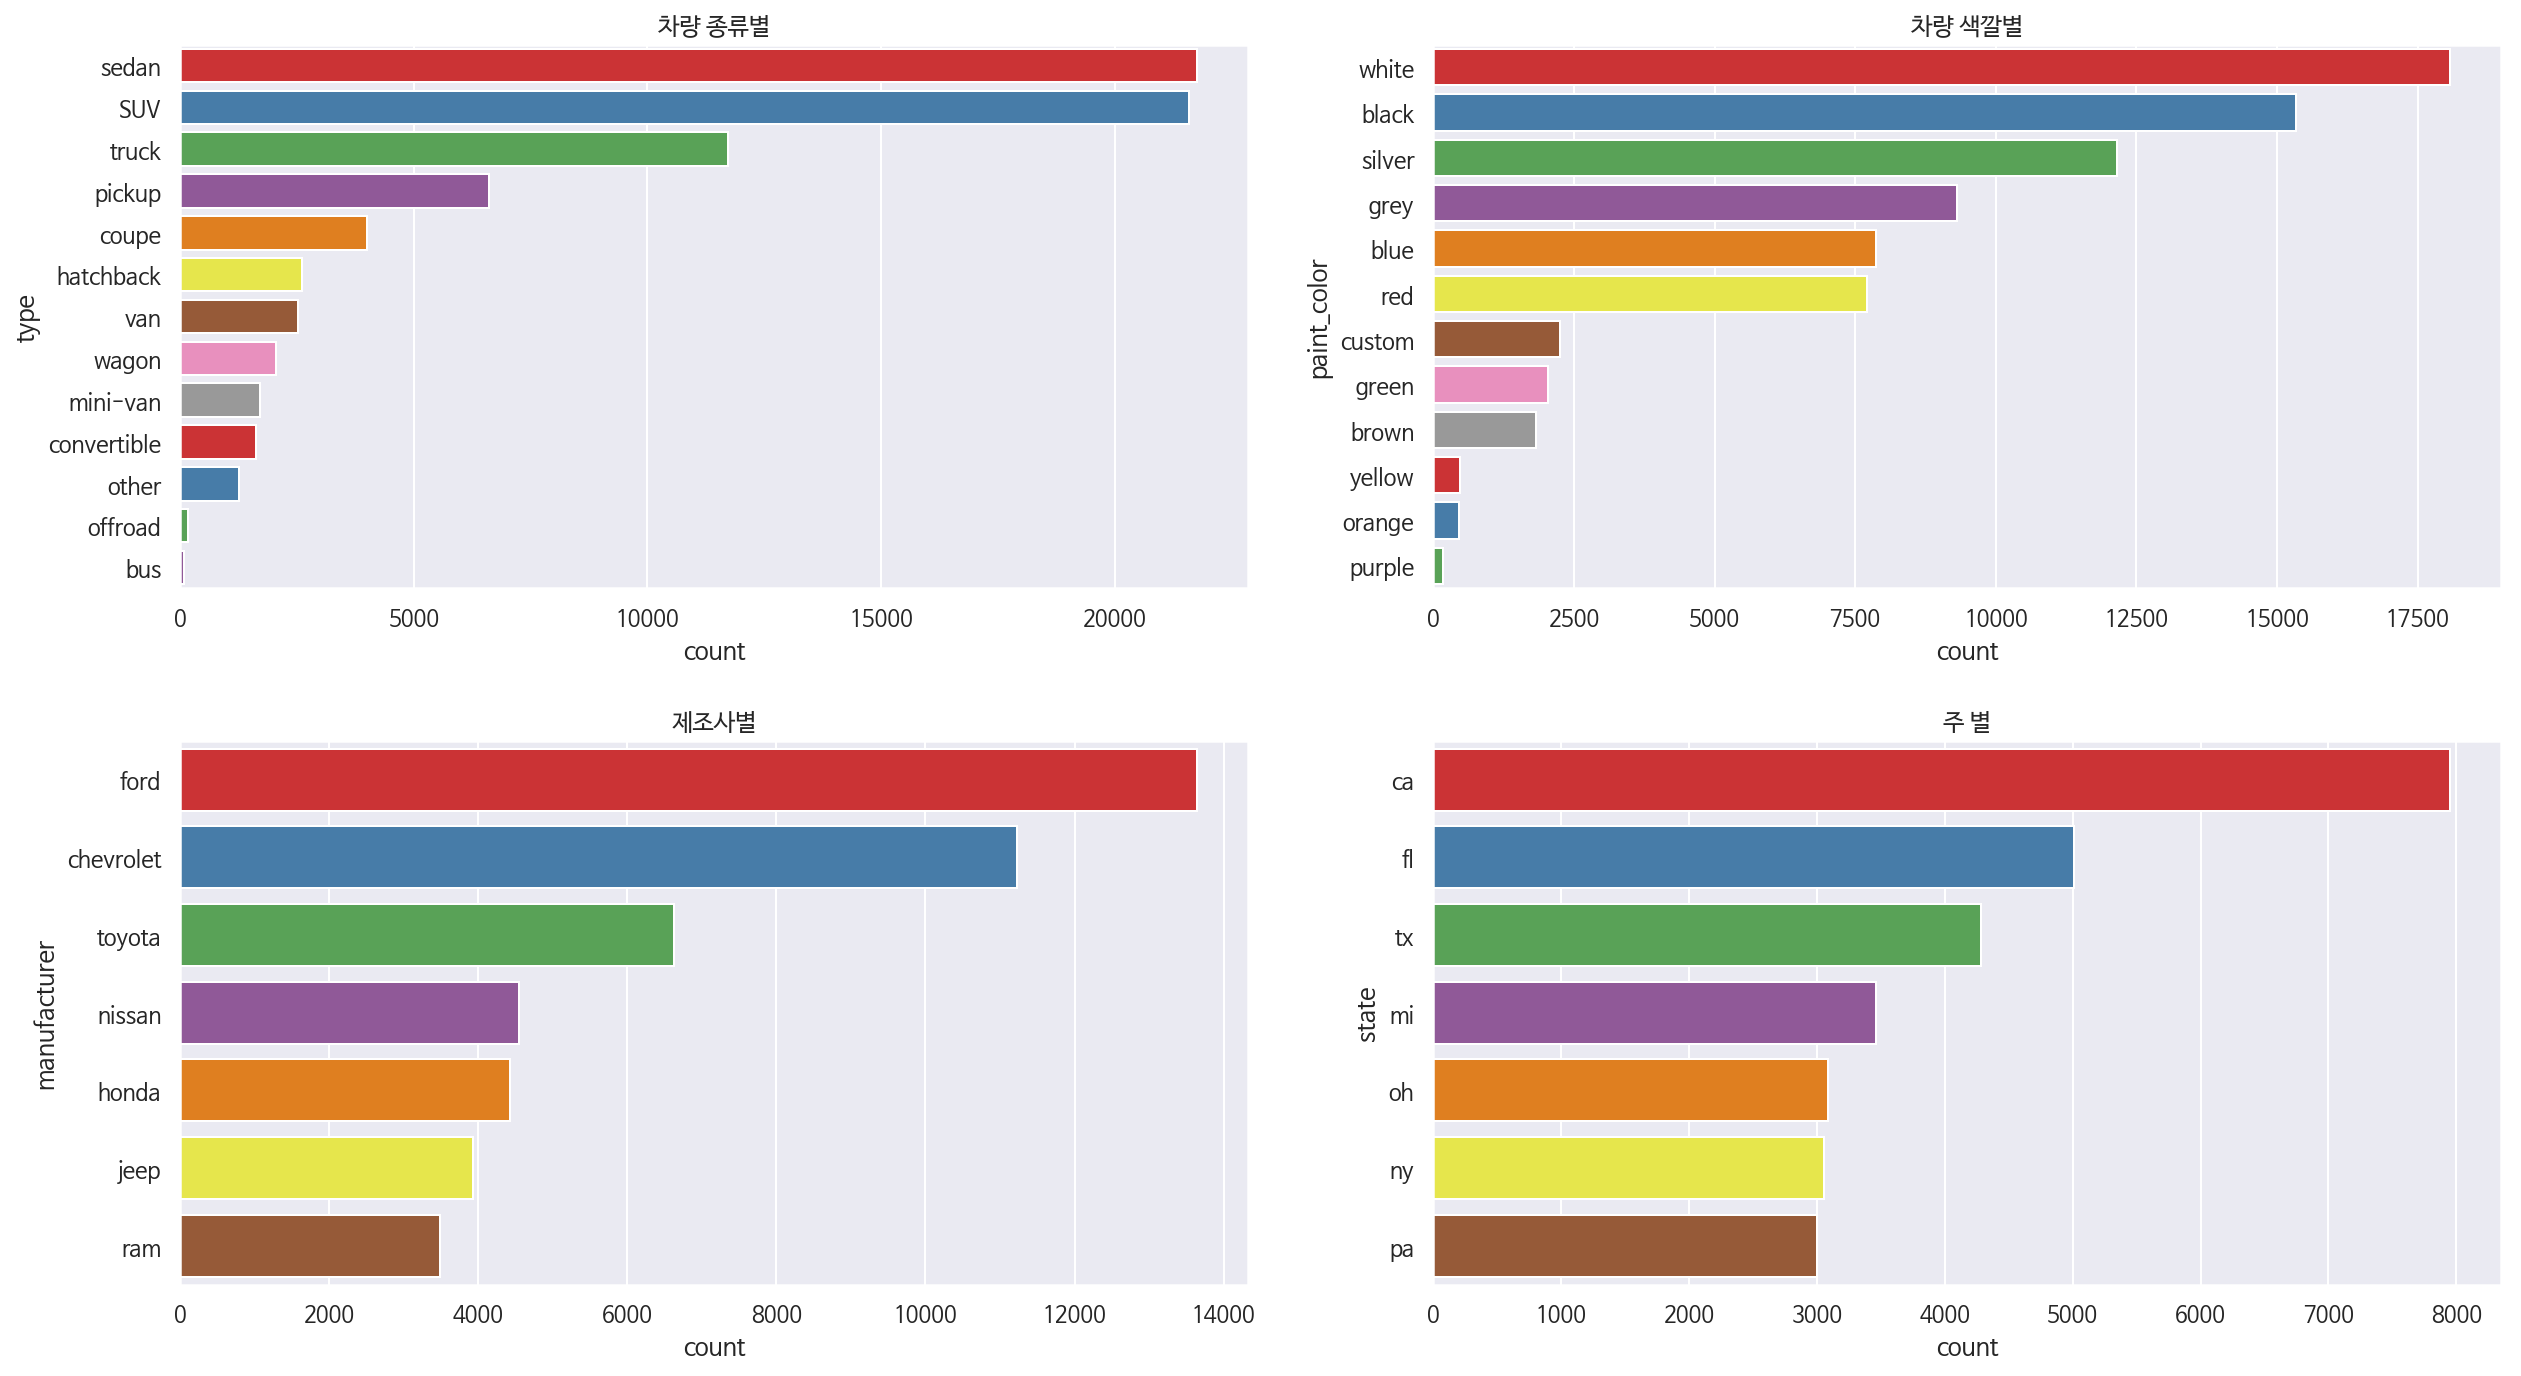

In [283]:
plt.figure(figsize=(18,10))

plt.subplot(221)
sns.countplot(
    data = df,
    y = "type",
    palette='Set1',
    order = df['type'].value_counts().index
)
plt.title("차량 종류별")


plt.subplot(222)
sns.countplot(
    data = df,
    y = "paint_color",
    palette='Set1',
    order = df['paint_color'].value_counts().index

)
plt.title("차량 색깔별")

plt.subplot(223)
sns.countplot(
    data = df,
    y = "manufacturer",
    palette='Set1',
    order = df['manufacturer'].value_counts().iloc[:7].index,

)
plt.title("제조사별")

plt.subplot(224)
sns.countplot(
    data = df,
    y = "state",
    palette='Set1',
    order = df['state'].value_counts().iloc[:7].index
)
plt.title("주 별")
plt.tight_layout()
plt.show()

##  pariplot

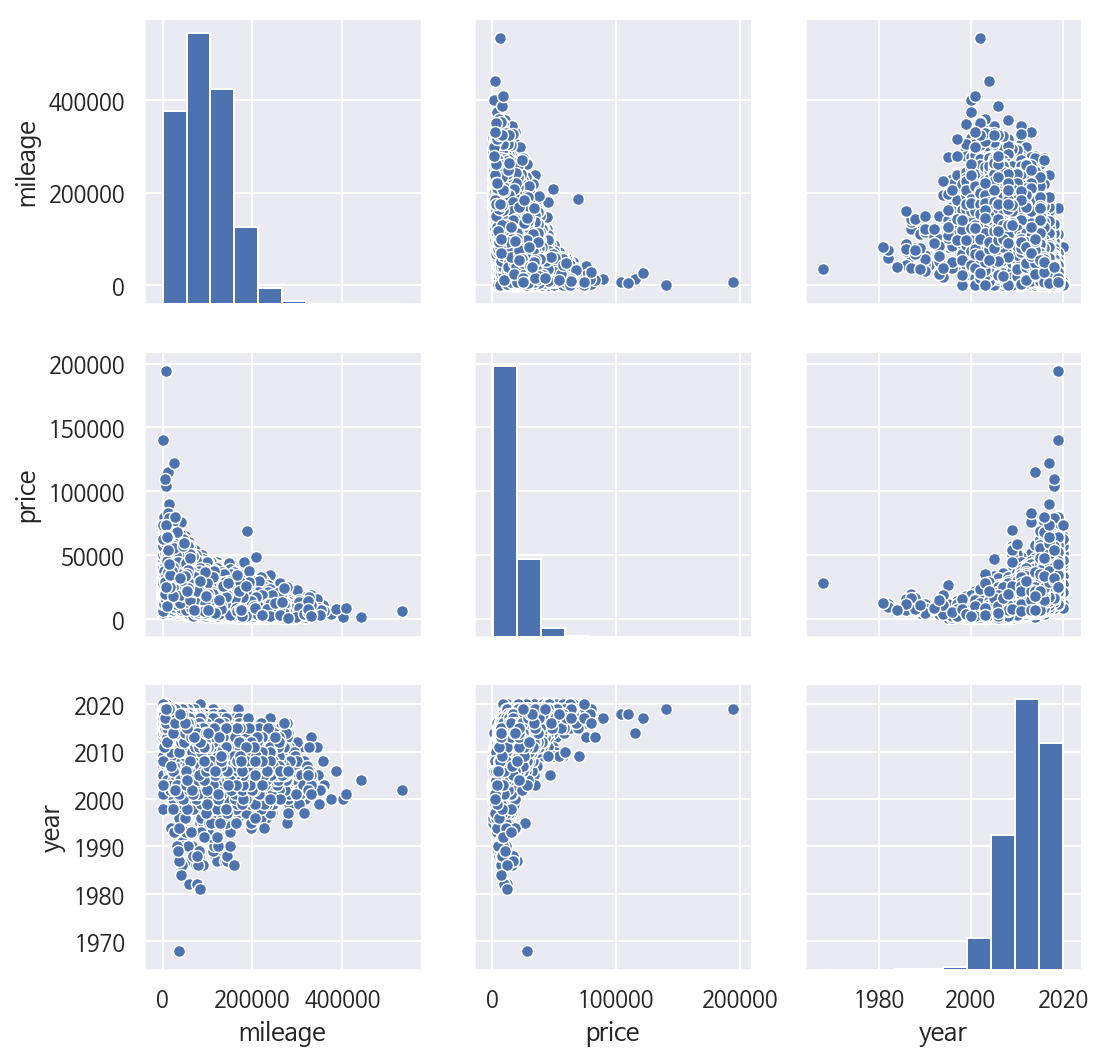

In [372]:
sns.pairplot(test2[test2.columns.difference(['id_x'])])

# 모델

### column 정리
- 모델을 만드는데 필요한 컬럼만 따로 분류

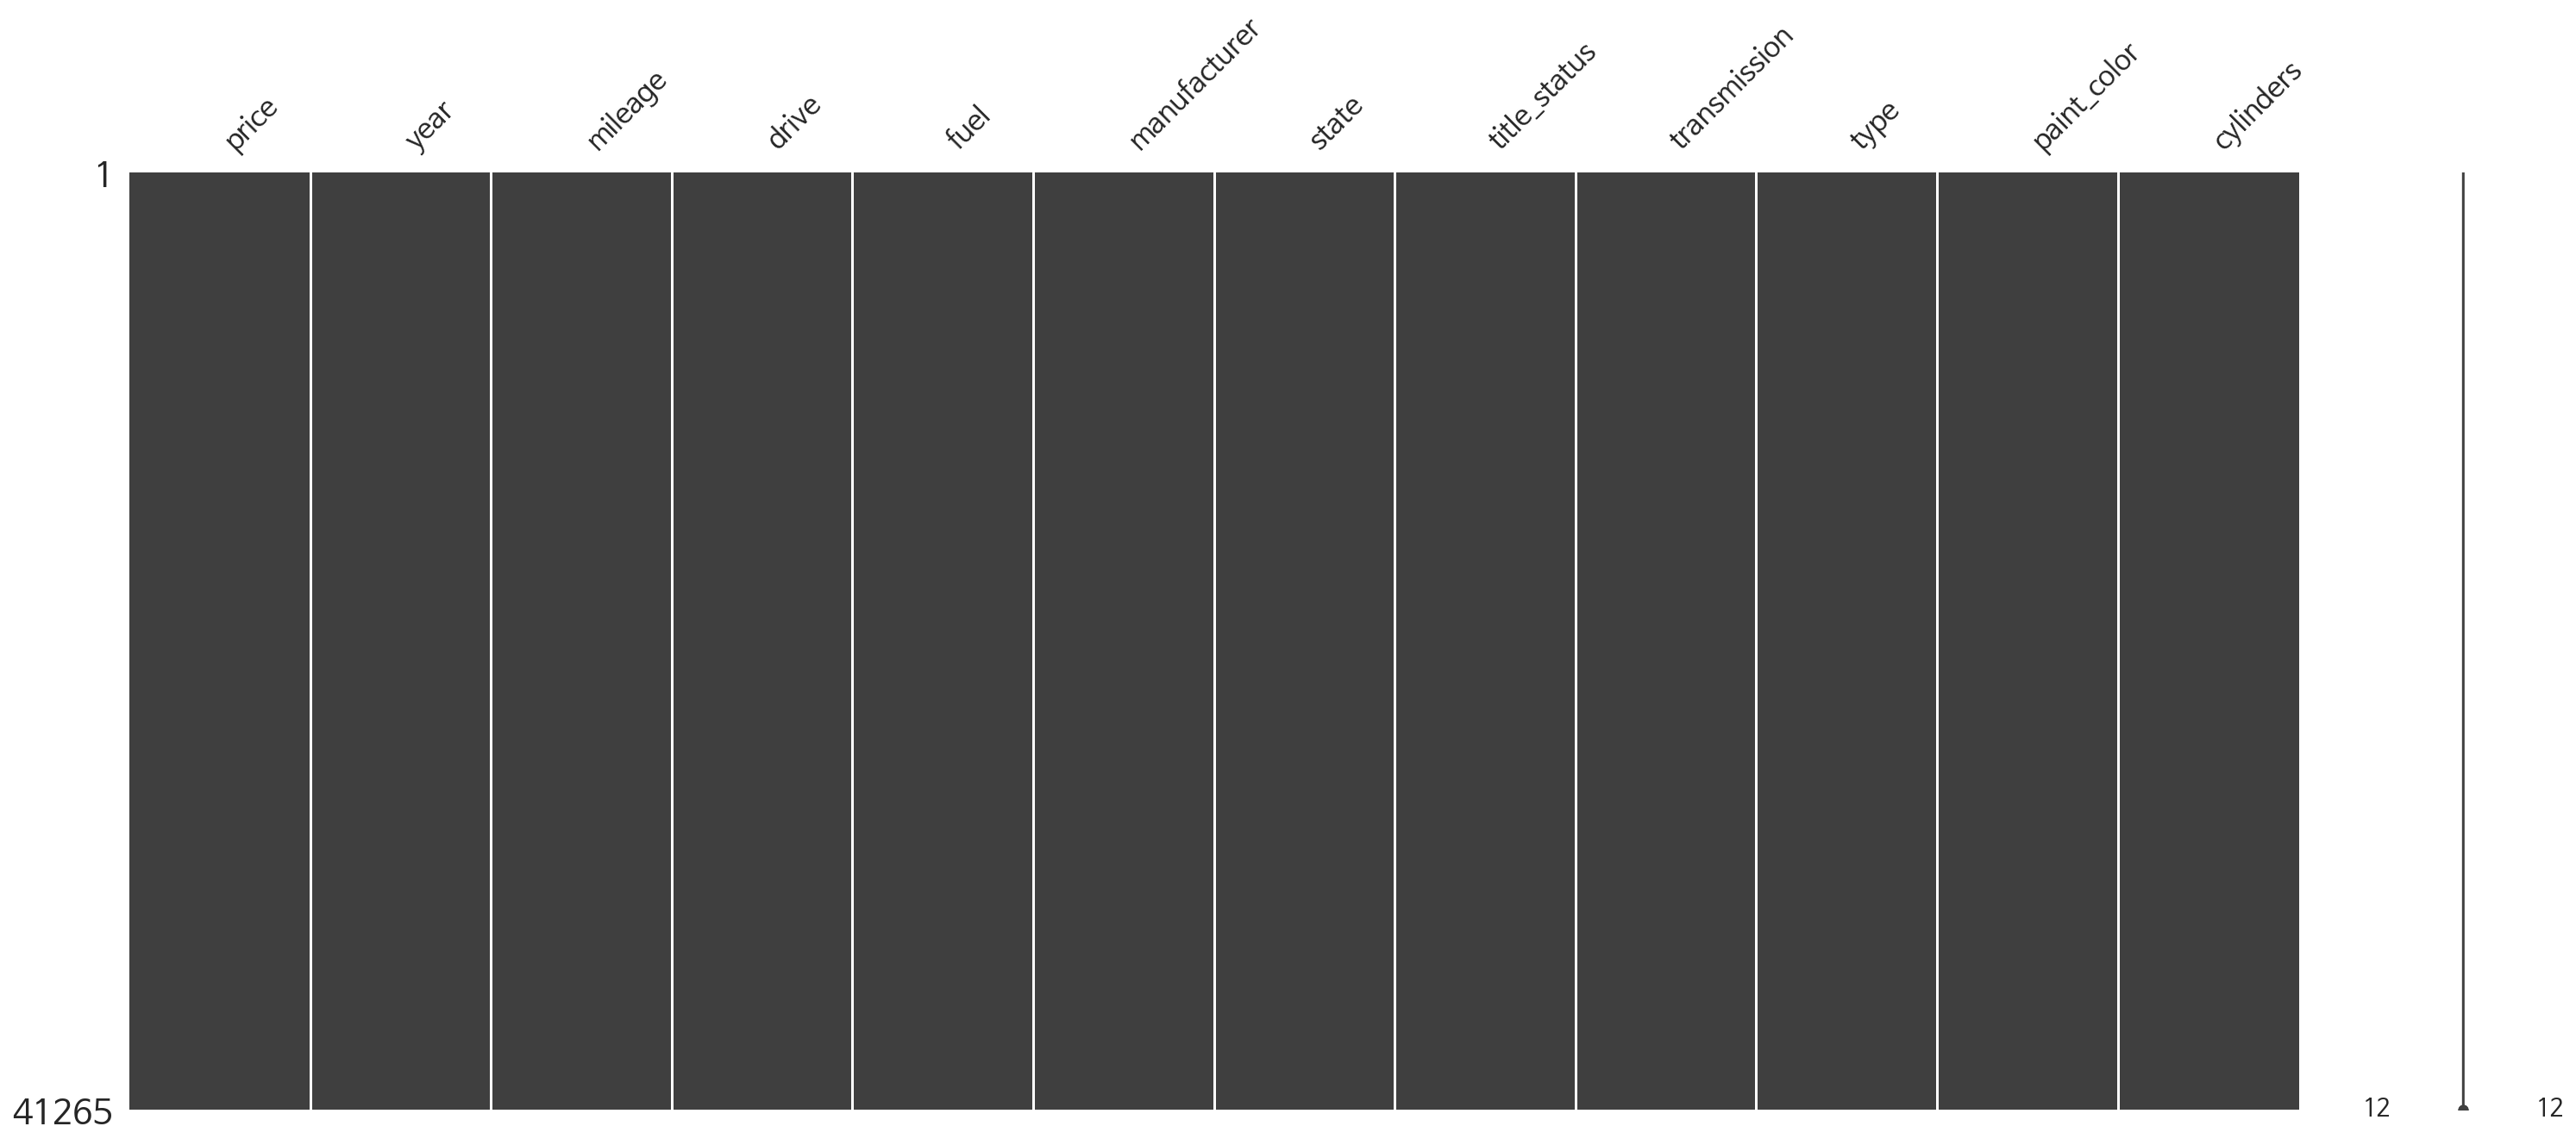

In [145]:
msno.matrix(test2)

In [146]:
test2.columns

Index(['price', 'year', 'mileage', 'drive', 'fuel', 'manufacturer', 'state',
       'title_status', 'transmission', 'type', 'paint_color', 'cylinders'],
      dtype='object')

In [155]:
test2 = test2[['price','year','mileage','drive','fuel','manufacturer','state','title_status','transmission','type','paint_color','cylinders']]
test2.shape

(41265, 12)

- linear_model

0.7789172334218697
RMSE of Train Data :  4512.823987339433
RMSE of Test Data :  4434.556837696542


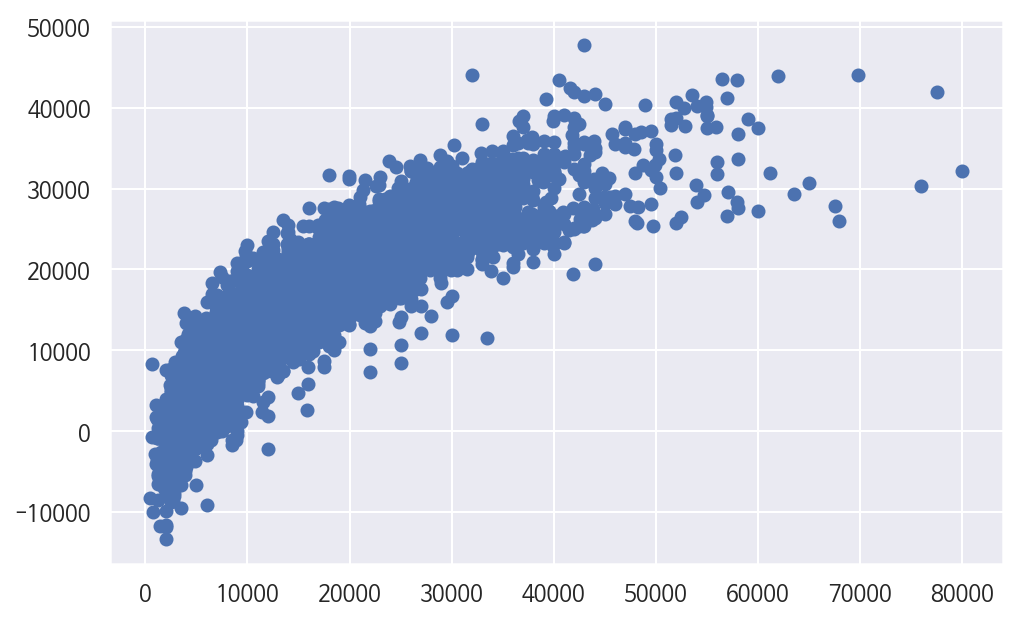

In [157]:
X = test2[test2.columns.difference(['id_x','model','vin','price'])]
Y = test2['price']
X = pd.get_dummies(data=X, drop_first=True)


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .20, random_state = 40)

test_df = pd.concat([Y_train,X_train],axis=1)

model = linear_model.LinearRegression() 
result = model.fit(X_train, Y_train)
predicted = result.predict(X_test)
print(r2_score(Y_test,predicted))
plt.scatter(Y_test,predicted)


pred_tr = result.predict(X_train)
pred_test = result.predict(X_test)
rmse_tr = (np.sqrt(mean_squared_error(Y_train, pred_tr)))
rmse_test = (np.sqrt(mean_squared_error(Y_test, pred_test)))

print('RMSE of Train Data : ', rmse_tr)
print('RMSE of Test Data : ', rmse_test)

In [156]:
X = test2[test2.columns.difference(['id_x','model','vin','price'])]
Y = test2['price']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .20, random_state = 40)

test_df = pd.concat([Y_train,X_train],axis=1)


model = sm.OLS.from_formula("scale(price) ~ scale(mileage) + C(year) +{}".format("+".join(test_df.columns.difference(['price','odometer','year','vin','odometer','vehicle'])))+"+0",test_df)
result = model.fit()
prediction = result.predict(X_test)
print(r2_score(Y_test,prediction))
print(result.summary())

-2.1002464503217166
                            OLS Regression Results                            
Dep. Variable:           scale(price)   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     736.0
Date:                Tue, 31 Mar 2020   Prob (F-statistic):               0.00
Time:                        23:01:34   Log-Likelihood:                -20994.
No. Observations:               33012   AIC:                         4.233e+04
Df Residuals:                   32842   BIC:                         4.376e+04
Df Model:                         169                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

### condition 있을때
- -2.1002461896459708

- 0.780259587472125
- RMSE of Train Data :  4497.6441272314205
- RMSE of Test Data :  4421.0736322420125
### condition 없을때
- -2.1002464503217166
- 0.7789172334218697
- RMSE of Train Data :  4512.823987339433
- RMSE of Test Data :  4434.556837696542